In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import matplotlib.dates  as mdates

from datetime   import datetime, timezone
from legendmeta import LegendMetadata

lmeta = LegendMetadata('/Users/romoluque_c/Repositories/legend-metadata/')

In [3]:
run_dict = {'p03':{'r000':{},'r001':{},'r002':{},'r003':{},'r004':{},'r005':{}},
            'p04':{'r000':{},'r001':{},'r002':{},'r003':{}},
            'p06':{'r000':{},'r001':{},'r002':{},'r003':{},'r004':{},'r005':{}},
            'p07':{          'r001':{},'r002':{},'r003':{},'r004':{},'r005':{},'r006':{},'r007':{}}}
            #'p08':{          'r001':{},'r002':{},'r003':{},'r004':{},'r005':{},'r006':{}}}

In [4]:
data_path = '/Users/romoluque_c/LEGEND/Energy_scale_group/Partitioning/data_example/'

In [5]:
dt    = datetime(2023, 4, 22, 5, 54, 22, tzinfo=timezone.utc)
chmap = lmeta.hardware.configuration.channelmaps.on(dt)
channel_dict = {}
for channel_name, channel_data in chmap.items():
    try:
        channel_dict[channel_data['daq']['rawid']] = (lmeta.channelmap(dt)[channel_name].type,
                                                      channel_name,
                                                      lmeta.channelmap(dt)[channel_name].production['mass_in_g'],
                                                      lmeta.channelmap(dt)[channel_name].location  ['string'],
                                                      lmeta.channelmap(dt)[channel_name].location  ['position'])
    except:
        continue

In [6]:
channel_dict;

In [7]:
for key, value in channel_dict.items():
    if value[0]== 'coax':
        print(key, value)

1107203 ('coax', 'C000RG1', 2113, 2, 2)
1107204 ('coax', 'C000RG2', 2168, 2, 3)
1107205 ('coax', 'C00ANG3', 2399, 2, 4)
1108800 ('coax', 'C00ANG5', 2748, 2, 5)
1108801 ('coax', 'C00ANG2', 2838, 2, 6)
1120005 ('coax', 'C00ANG4', 2375, 8, 3)


In [8]:
def cal_energy(e_uncal, cal_pars):
    if len(cal_pars.keys())==2:
        #print('lin')
        return cal_pars['a'] * e_uncal + cal_pars['b'], 'lin'
    elif len(cal_pars.keys())==3:
        #print('quad')
        return cal_pars['a'] * e_uncal **2 + cal_pars['b'] * e_uncal + cal_pars['c'], 'quad'

In [9]:
def uncal_quad(e_cal, cal_pars):
    return (-cal_pars['b']+np.sqrt(cal_pars['b']**2-2*cal_pars['a']*(cal_pars['c']-e_cal)))/(2*cal_pars['a'])

### Let's choose the 6 coaxial detectors

In [10]:
all_params_ch = {}
all_channels  = ['ch1107203', 'ch1107204', 'ch1107205', 'ch1108800', 'ch1108801', 'ch1120005']
for sel_channel in all_channels:
    
    pars_per_ch = {'mus_peaks':        {}, 'mus_err_peaks':   {},
                   'fwhms_peaks':      {}, 'fwhms_err_peaks': {},
                   'ecals_peaks':      {},
                   'Qbb_fwhms_in_keV': [], 'Qbb_fwhms_err_in_keV': [],
                   'eres_lin_pars0':   [], 'eres_lin_pars0_err':   [],
                   'eres_lin_pars1':   [], 'eres_lin_pars1_err':   [],
                   'gains':            [], 'Qbb_fwhms_in_ADC':     []}
    
    for i, period in enumerate(run_dict.keys()):
        for j, run in enumerate(run_dict[period].keys()):
            all_files = os.listdir(data_path)
            filename  = data_path + [f for f in all_files if f.startswith(f'l200-{period}-{run}')][0]
            with open (filename, 'r') as filehandler:
                results   = json.load(filehandler)
                res_chn   = results[sel_channel]['results']['ecal']
    
                ## Parameters for calibration
                cal_parameters = results[sel_channel]['pars']['operations']['cuspEmax_ctc_cal']['parameters']
                
                ## Parameters for resolution curve
                eres_lin_pars = res_chn['cuspEmax_ctc_cal']['eres_linear']

                pars_per_ch['Qbb_fwhms_in_keV']    .append({f'{period}-{run}': eres_lin_pars['Qbb_fwhm_in_keV']})
                pars_per_ch['Qbb_fwhms_err_in_keV'].append({f'{period}-{run}': eres_lin_pars['Qbb_fwhm_err_in_keV']})
                pars_per_ch['eres_lin_pars0']      .append({f'{period}-{run}': eres_lin_pars['parameters']   ['a']})
                pars_per_ch['eres_lin_pars0_err']  .append({f'{period}-{run}': eres_lin_pars['uncertainties']['a']})
                pars_per_ch['eres_lin_pars1']      .append({f'{period}-{run}': eres_lin_pars['parameters']   ['b']})
                pars_per_ch['eres_lin_pars1_err']  .append({f'{period}-{run}': eres_lin_pars['uncertainties']['b']})
                pars_per_ch['gains']               .append({f'{period}-{run}': cal_parameters['b']})
                pars_per_ch['Qbb_fwhms_in_ADC']    .append({f'{period}-{run}': uncal_quad(eres_lin_pars['Qbb_fwhm_in_keV'], cal_parameters)})
                
                fitted_peaks   = res_chn['cuspEmax_ctc_cal']['fitted_peaks']
                peak_fits_pars = res_chn['cuspEmax_ctc_cal']['pk_fits']
                
                for peak in fitted_peaks:
                    if i==0 and j==0:
                        pars_per_ch['mus_peaks']      [peak] = {}
                        pars_per_ch['mus_err_peaks']  [peak] = {}
                        pars_per_ch['fwhms_peaks']    [peak] = {}
                        pars_per_ch['fwhms_err_peaks'][peak] = {}
                        pars_per_ch['ecals_peaks']    [peak] = {}
                        
                    pars_per_ch['mus_peaks']      [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['parameters_in_ADC']   ['mu']
                    pars_per_ch['mus_err_peaks']  [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['uncertainties_in_ADC']['mu']
                    pars_per_ch['fwhms_peaks']    [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['fwhm_in_keV']         [0]   
                    pars_per_ch['fwhms_err_peaks'][peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['fwhm_in_keV']         [1]   
                    pars_per_ch['ecals_peaks']    [peak][f'{period}-{run}'] = cal_energy(peak_fits_pars[f'{peak}']['parameters_in_ADC']['mu'], cal_parameters)[0]

    all_params_ch[sel_channel] = pars_per_ch

In [11]:
labels = [f'{key}-{run}' for key in run_dict.keys() for run in run_dict[key].keys()]

### Position of the different peaks

In [12]:
all_fitted_peaks = np.array([583.191, 727.33, 860.564, 1592.53, 1620.5, 2103.53, 2614.5])

In [13]:
det_colors = ['#FF9E21', '#FFB28C', '#D88897', '#F4D070', 'indianred', 'salmon']

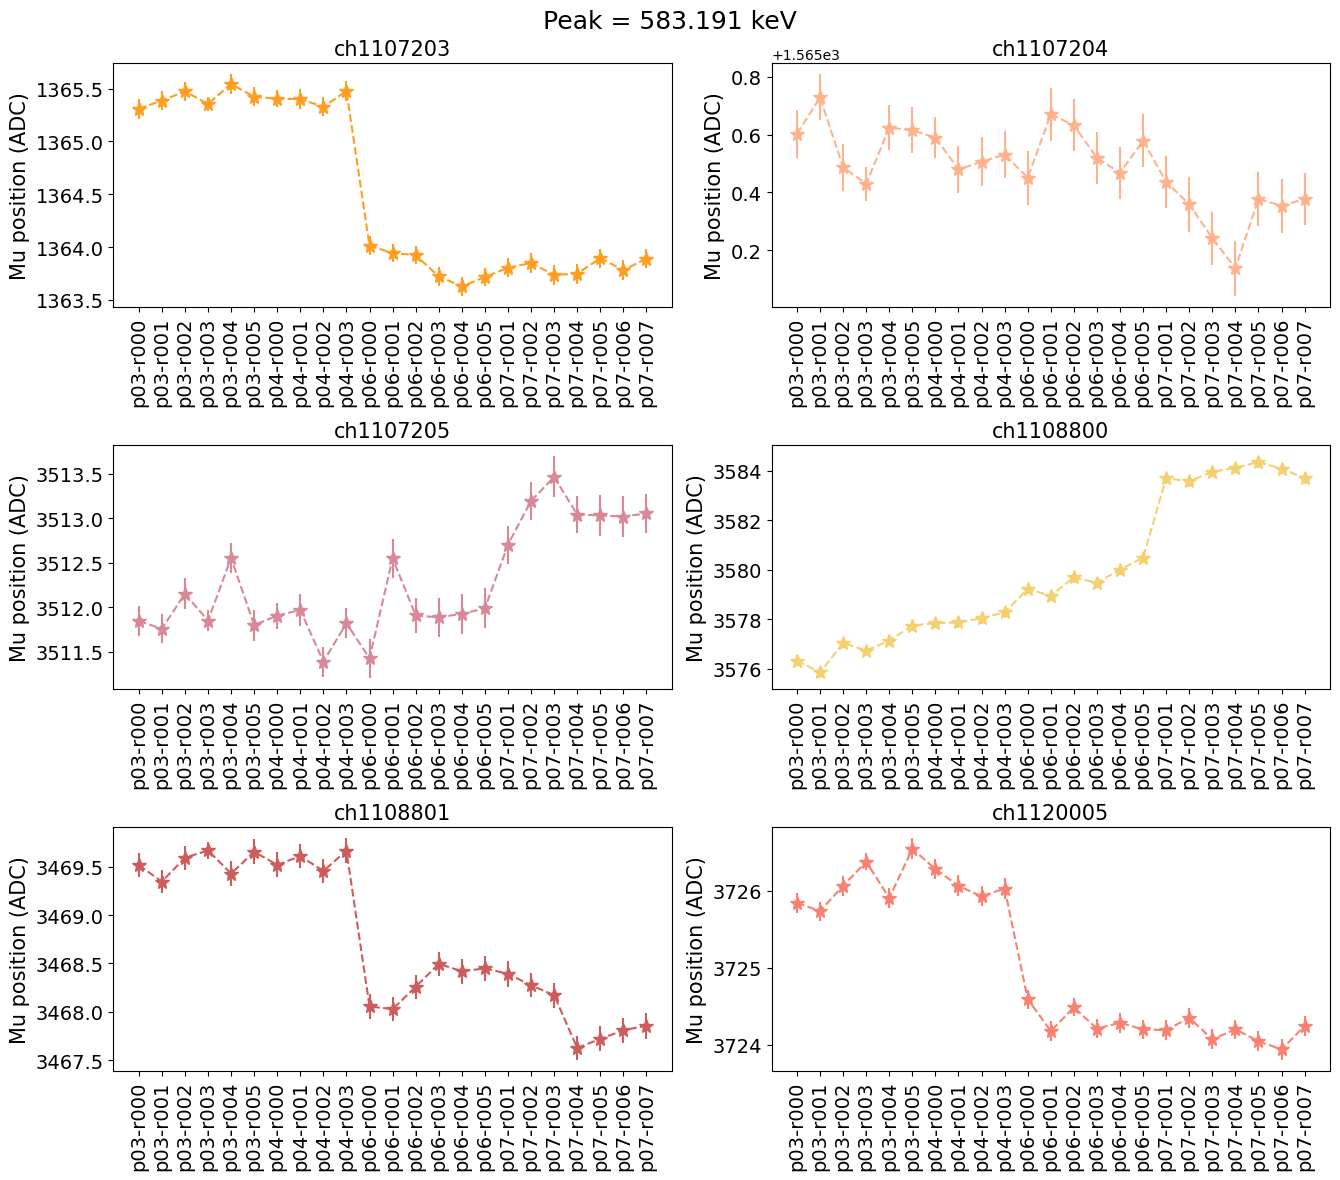


-------------------------------------------------------------------------------------------------



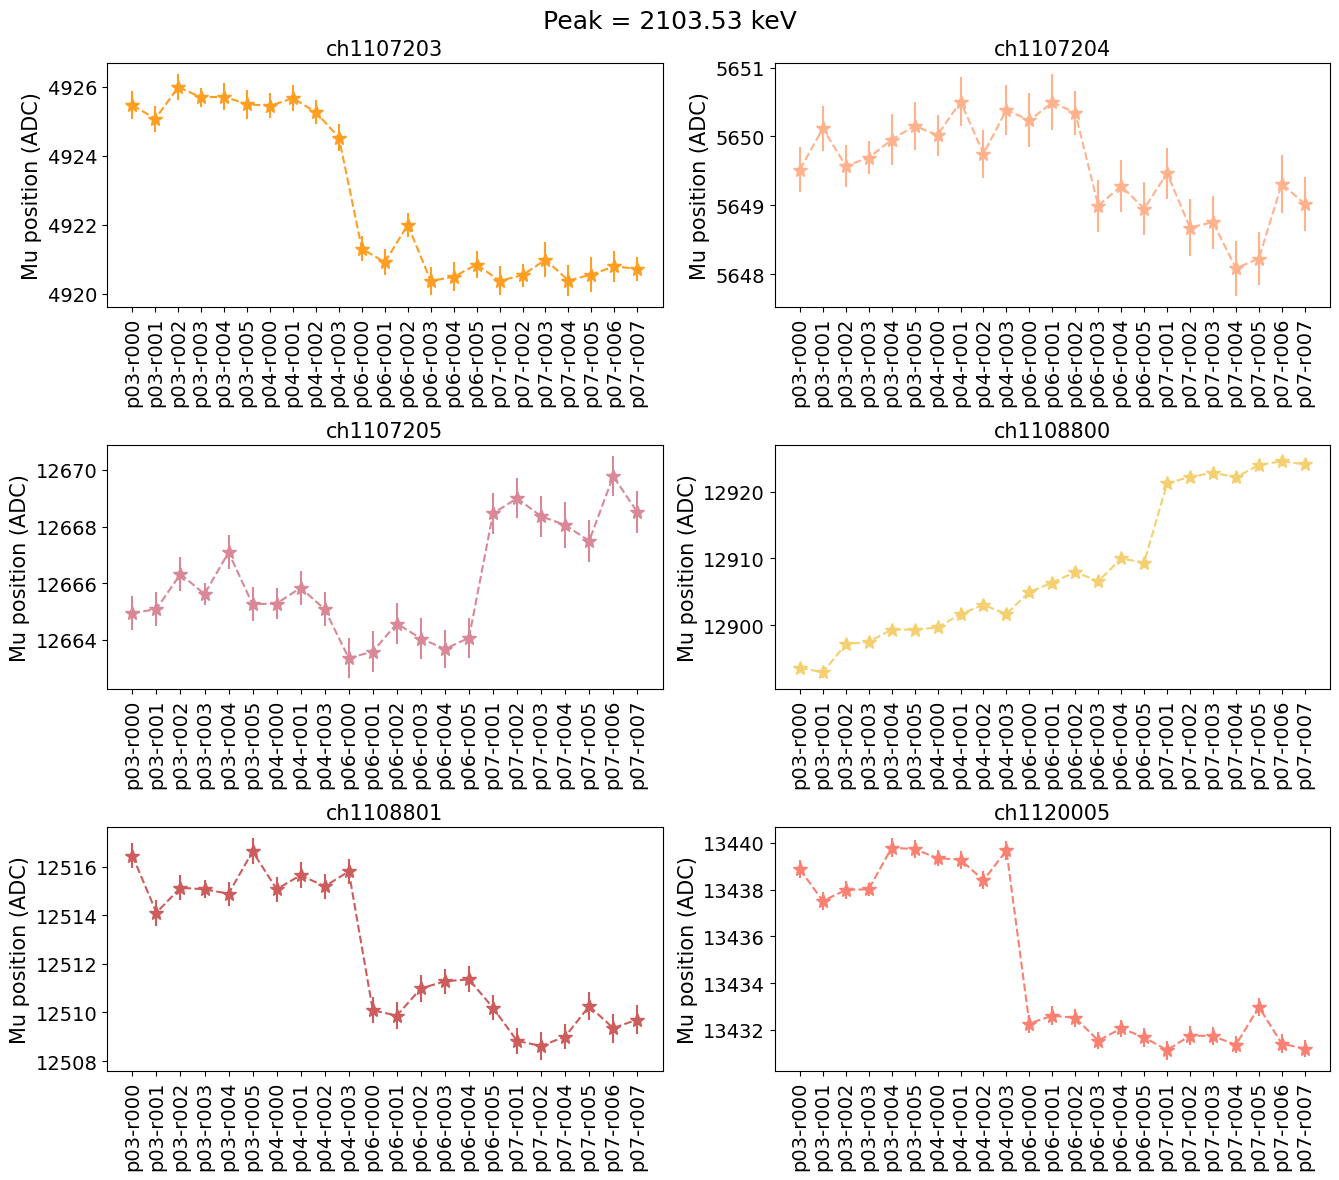


-------------------------------------------------------------------------------------------------



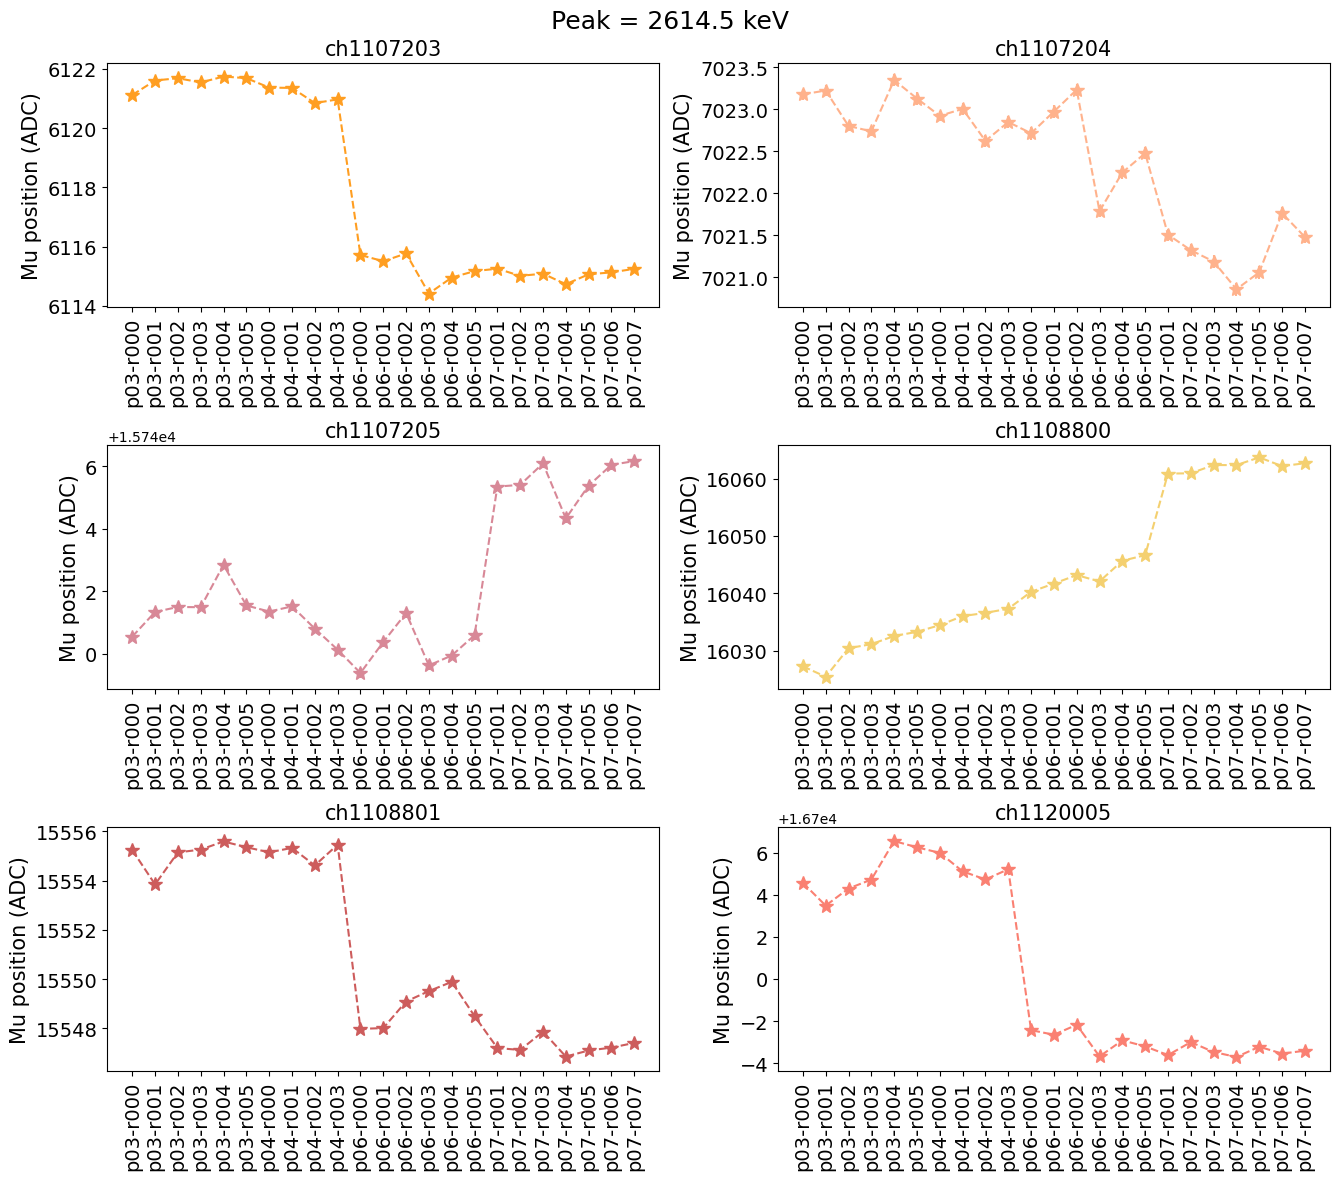


-------------------------------------------------------------------------------------------------



In [14]:
for peak in [all_fitted_peaks[0], all_fitted_peaks[5], all_fitted_peaks[6]]:
    fig, axs = plt.subplots(3, 2, figsize=(13.5, 12))
    for i, (ax, channel, col) in enumerate(zip(axs.flatten(), all_channels, det_colors)):
        ax.errorbar(list(all_params_ch[channel]['mus_peaks'][peak].keys()), 
                    list(all_params_ch[channel]['mus_peaks'][peak].values()),
                    yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()), 
                    marker='*', linestyle='--', markersize=10, label=channel, color=col)
        ax.tick_params(axis='x', labelsize=14, rotation=90)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_title(channel, fontsize=15)
        ax.set_ylabel('Mu position (ADC)', fontsize=15)
    fig.suptitle(f'Peak = {peak} keV', fontsize=18)
    plt.tight_layout()
    plt.show()
    print()
    print('-------------------------------------------------------------------------------------------------')
    print()

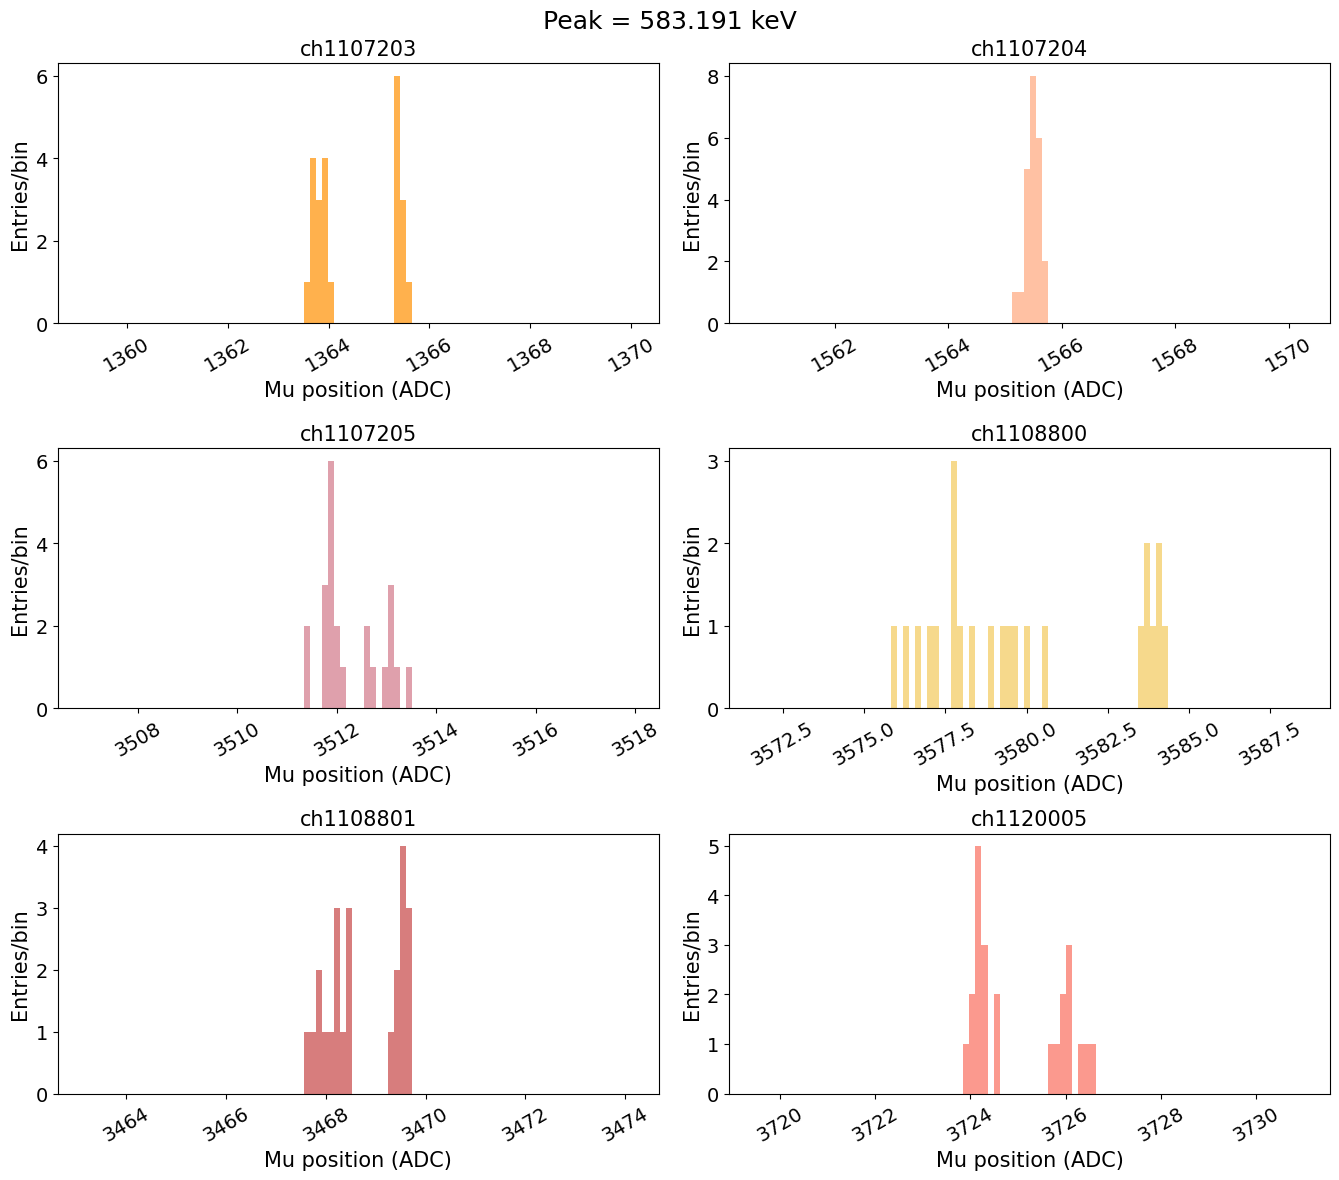


-------------------------------------------------------------------------------------------------



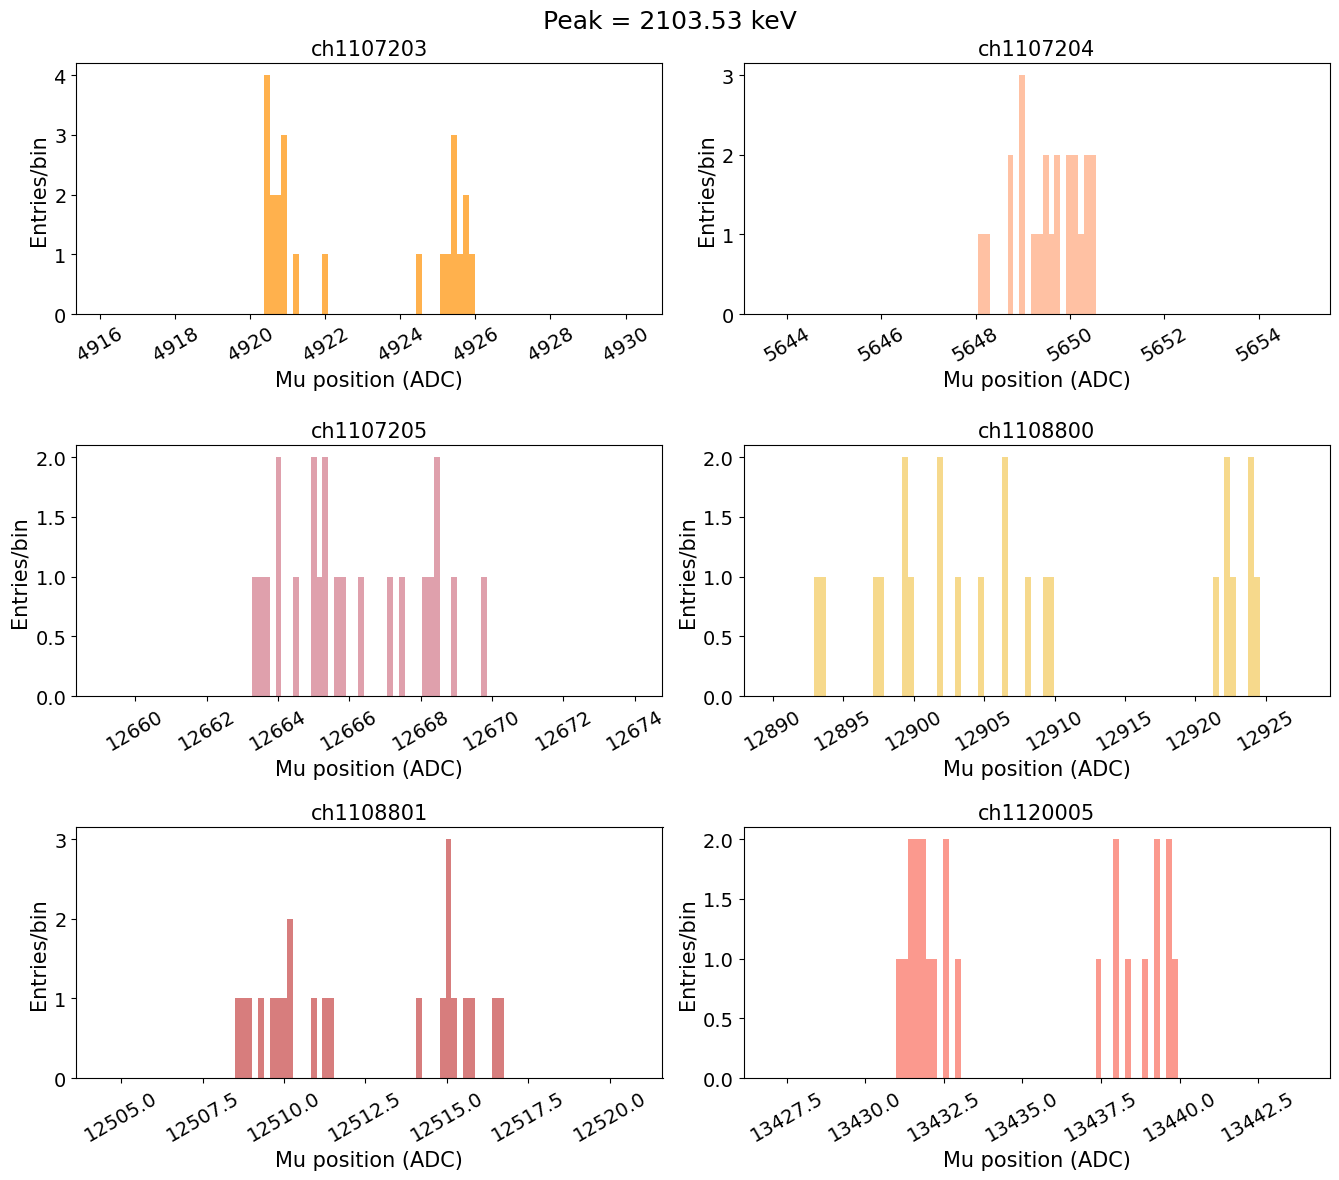


-------------------------------------------------------------------------------------------------



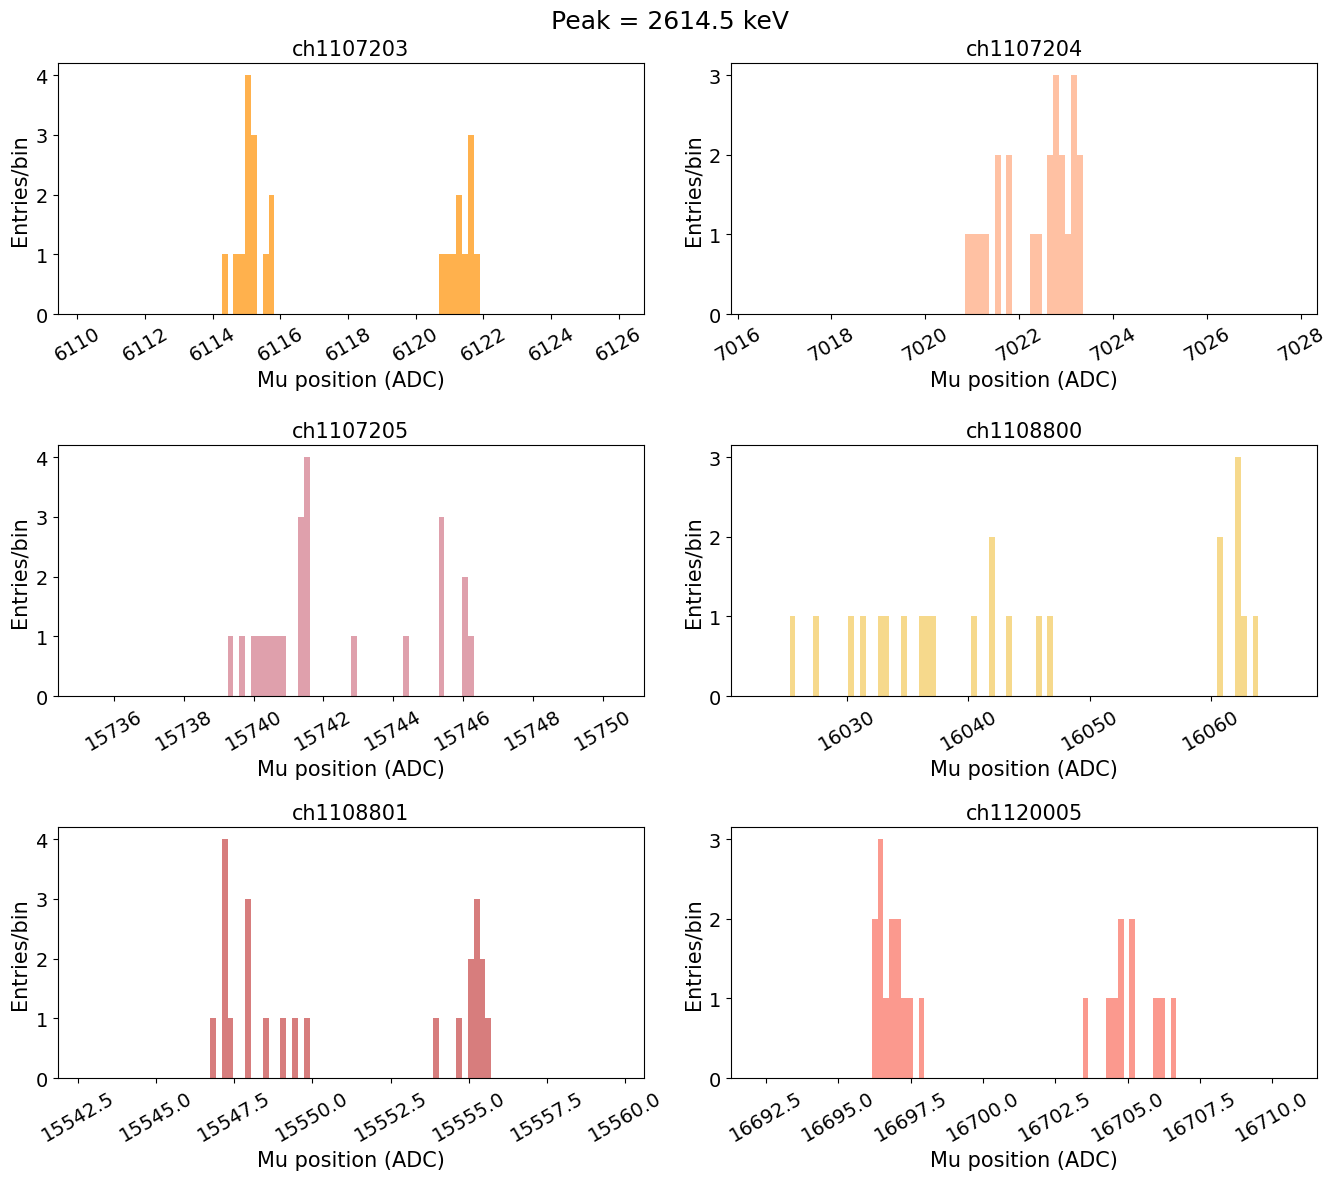


-------------------------------------------------------------------------------------------------



In [15]:
for peak in [all_fitted_peaks[0], all_fitted_peaks[5], all_fitted_peaks[6]]:
    fig, axs = plt.subplots(3, 2, figsize=(13.5, 12))
    for i, (ax, channel, col) in enumerate(zip(axs.flatten(), all_channels, det_colors)):
        ax.hist(list(all_params_ch[channel]['mus_peaks'][peak].values()), bins=100, label=channel, color=col, alpha=0.8,
               range=(min(list(all_params_ch[channel]['mus_peaks'][peak].values()))-5,
                      max(list(all_params_ch[channel]['mus_peaks'][peak].values()))+5))
        ax.tick_params(axis='x', labelsize=14, rotation=30)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_xlim(min(list(all_params_ch[channel]['mus_peaks'][peak].values()))-5,
                    max(list(all_params_ch[channel]['mus_peaks'][peak].values()))+5)
        ax.set_title(channel, fontsize=15)
        ax.set_xlabel('Mu position (ADC)', fontsize=15)
        ax.set_ylabel('Entries/bin', fontsize=15)
    fig.suptitle(f'Peak = {peak} keV', fontsize=18)
    plt.tight_layout()
    plt.show()
    print()
    print('-------------------------------------------------------------------------------------------------')
    print()

### Qbb FWHM for all the peaks

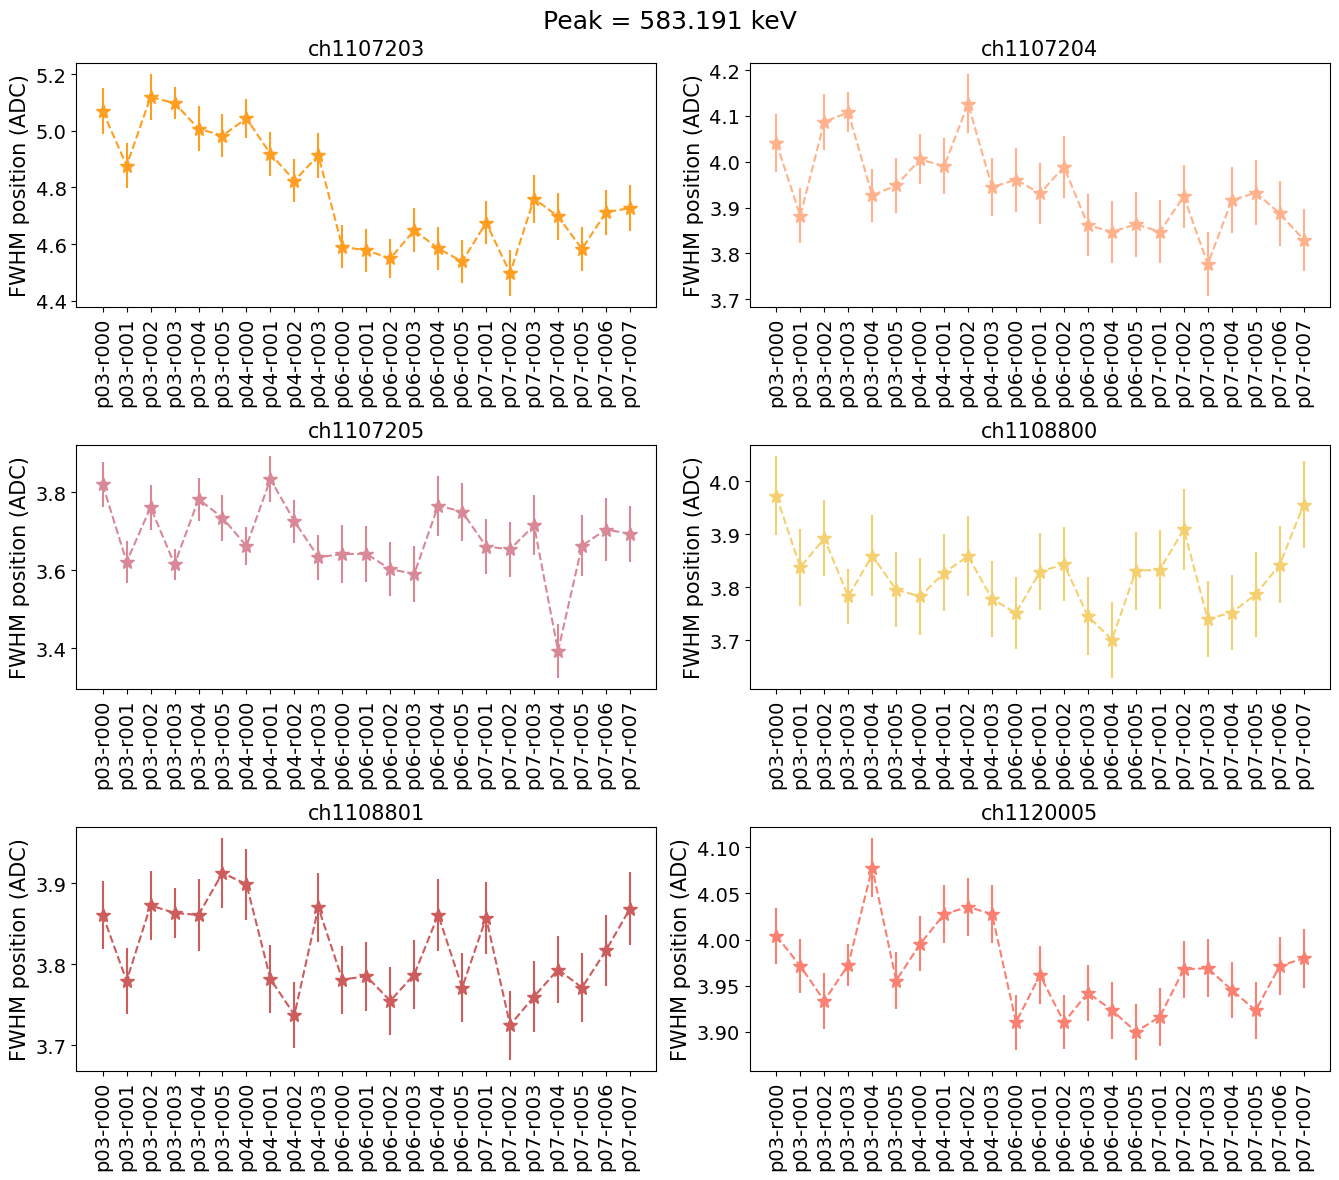


-------------------------------------------------------------------------------------------------



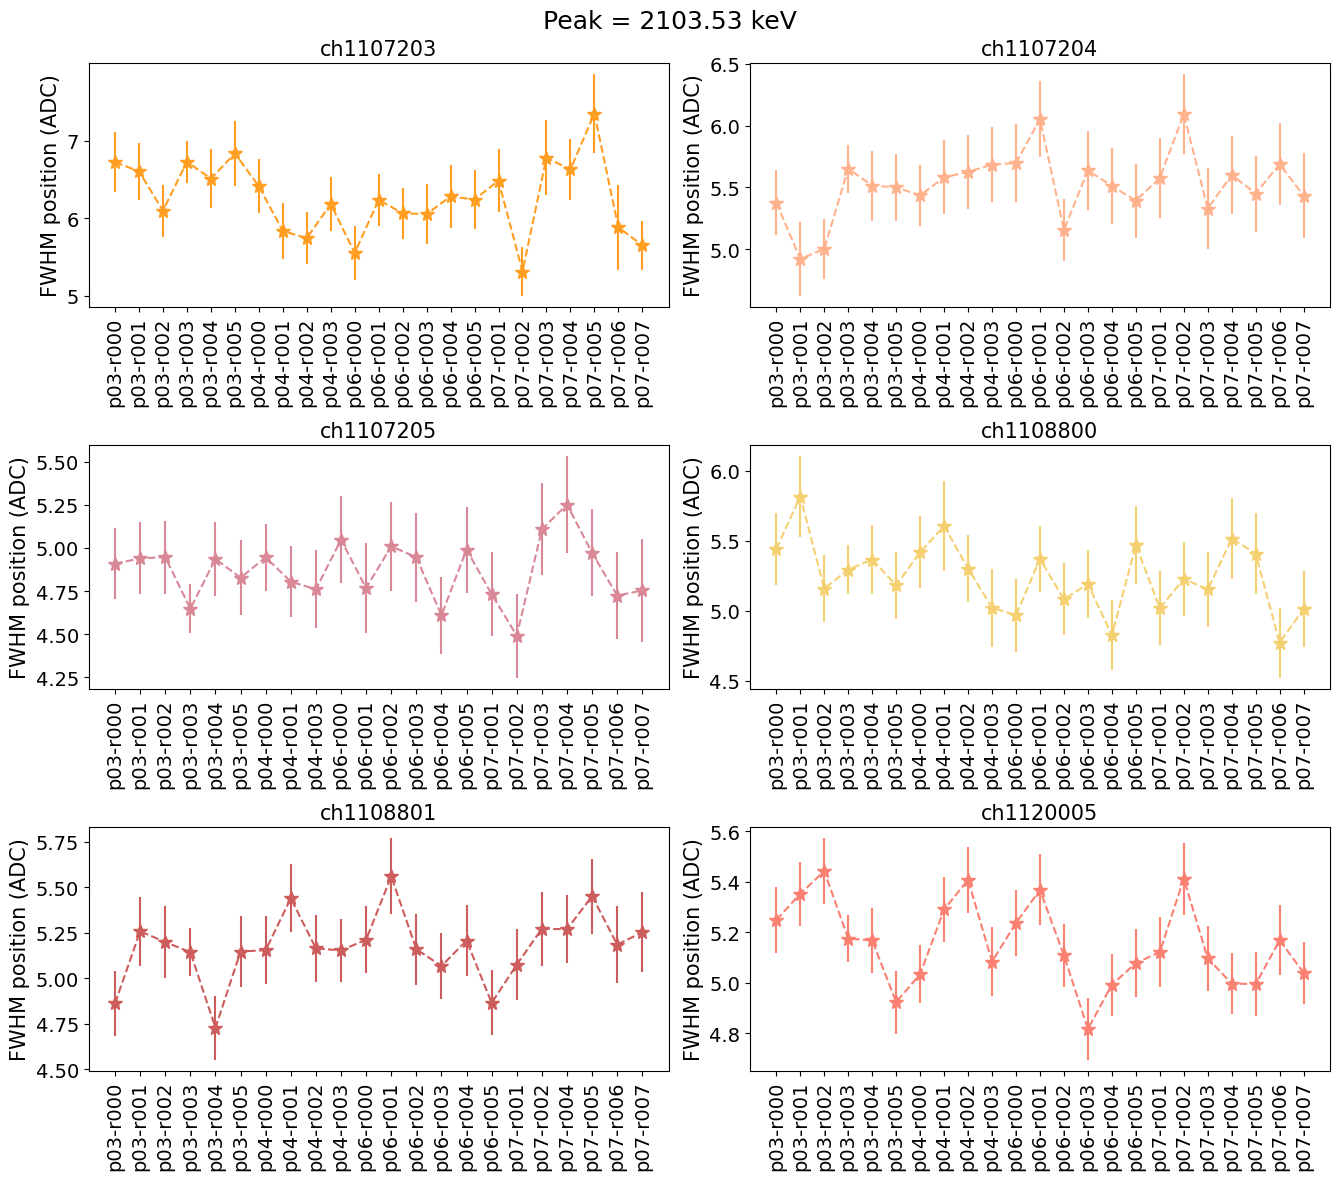


-------------------------------------------------------------------------------------------------



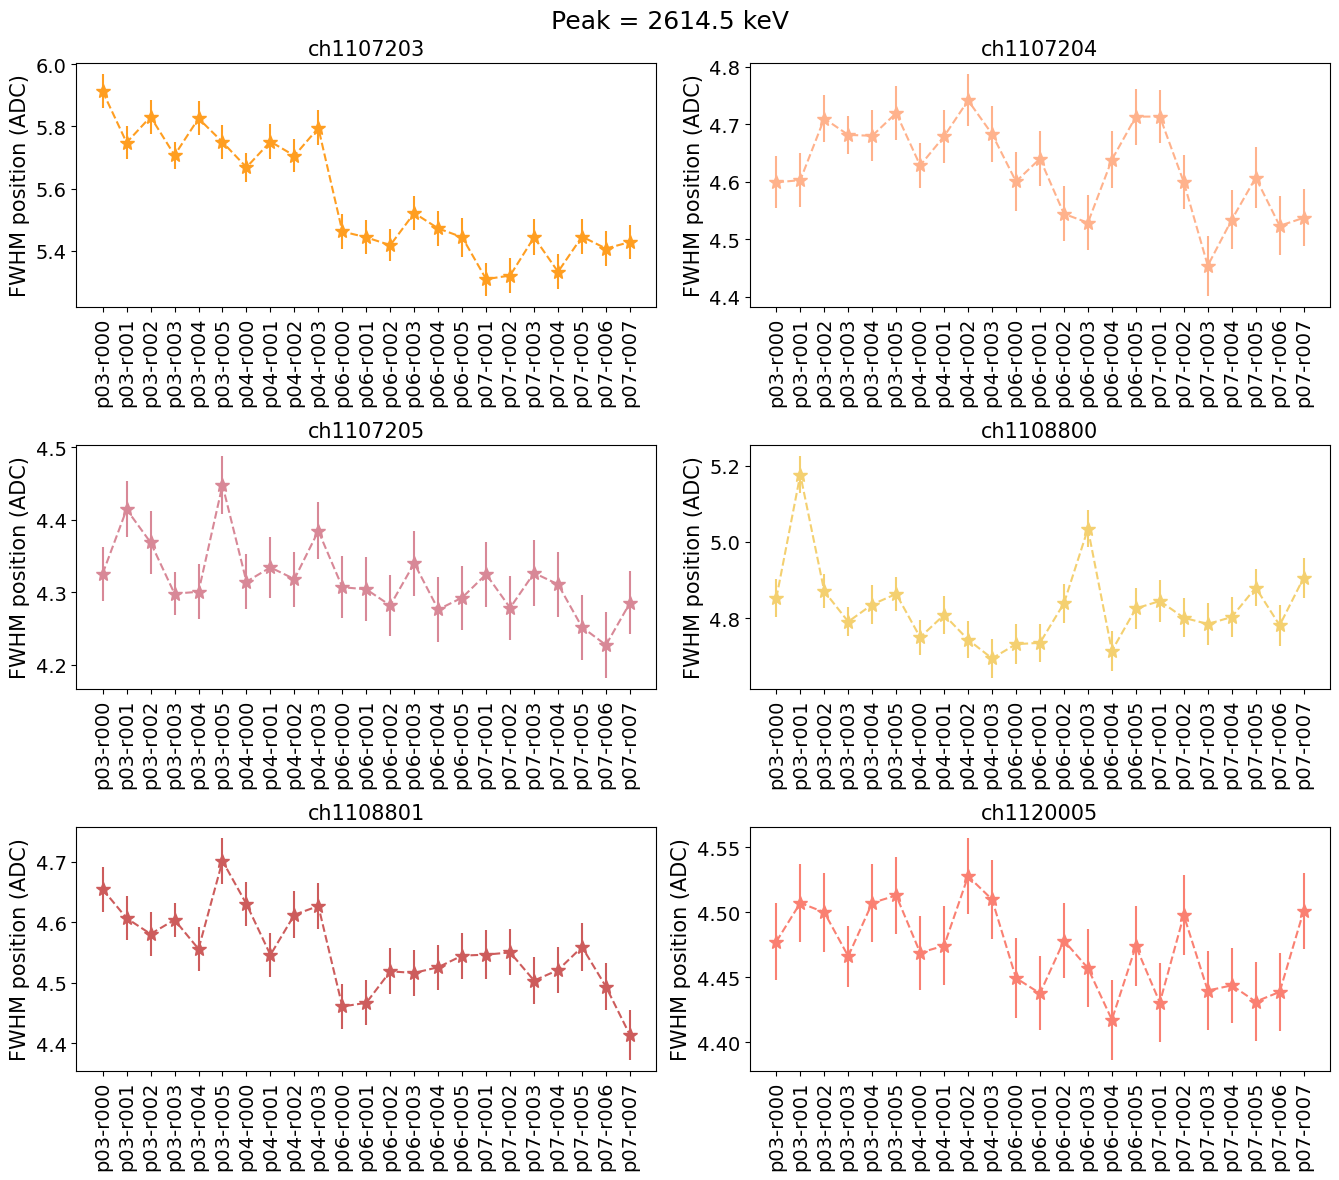


-------------------------------------------------------------------------------------------------



In [16]:
for peak in [all_fitted_peaks[0], all_fitted_peaks[5], all_fitted_peaks[6]]:
    fig, axs = plt.subplots(3, 2, figsize=(13.5, 12))
    for i, (ax, channel, col) in enumerate(zip(axs.flatten(), all_channels, det_colors)):
        ax.errorbar(list(all_params_ch[channel]['fwhms_peaks'][peak].keys()), 
                    list(all_params_ch[channel]['fwhms_peaks'][peak].values()),
                    yerr=list(all_params_ch[channel]['fwhms_err_peaks'][peak].values()),
                    marker='*', linestyle='--', markersize=10, label=channel, color=col)
        ax.tick_params(axis='x', labelsize=14, rotation=90)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_title(channel, fontsize=15)
        ax.set_ylabel('FWHM position (ADC)', fontsize=15)
    fig.suptitle(f'Peak = {peak} keV', fontsize=18)
    plt.tight_layout()
    plt.show()
    print()
    print('-------------------------------------------------------------------------------------------------')
    print()

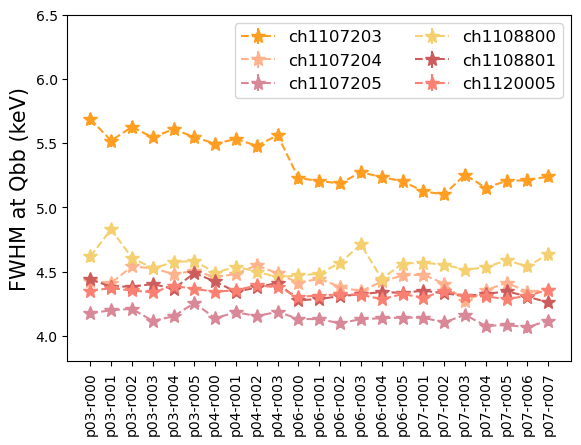

In [17]:
fig = plt.figure(figsize=(6.5, 4.5))
for i, (ax, channel, col) in enumerate(zip(axs.flatten(), all_channels, det_colors)):
    plt.errorbar([list(i.keys  ())[0] for i in all_params_ch[channel]['Qbb_fwhms_in_keV']],
                 [list(i.values())[0] for i in all_params_ch[channel]['Qbb_fwhms_in_keV']],
                 yerr=[list(i.values())[0] for i in all_params_ch[channel]['Qbb_fwhms_err_in_keV']],
                 marker='*', linestyle='--', markersize=10, color=col, label=channel)
plt.xticks(rotation=90)
plt.ylabel('FWHM at Qbb (keV)', fontsize=15)
plt.ylim(3.8, 6.5)
plt.legend(fontsize=12, ncol=2)
plt.show()

### Gain

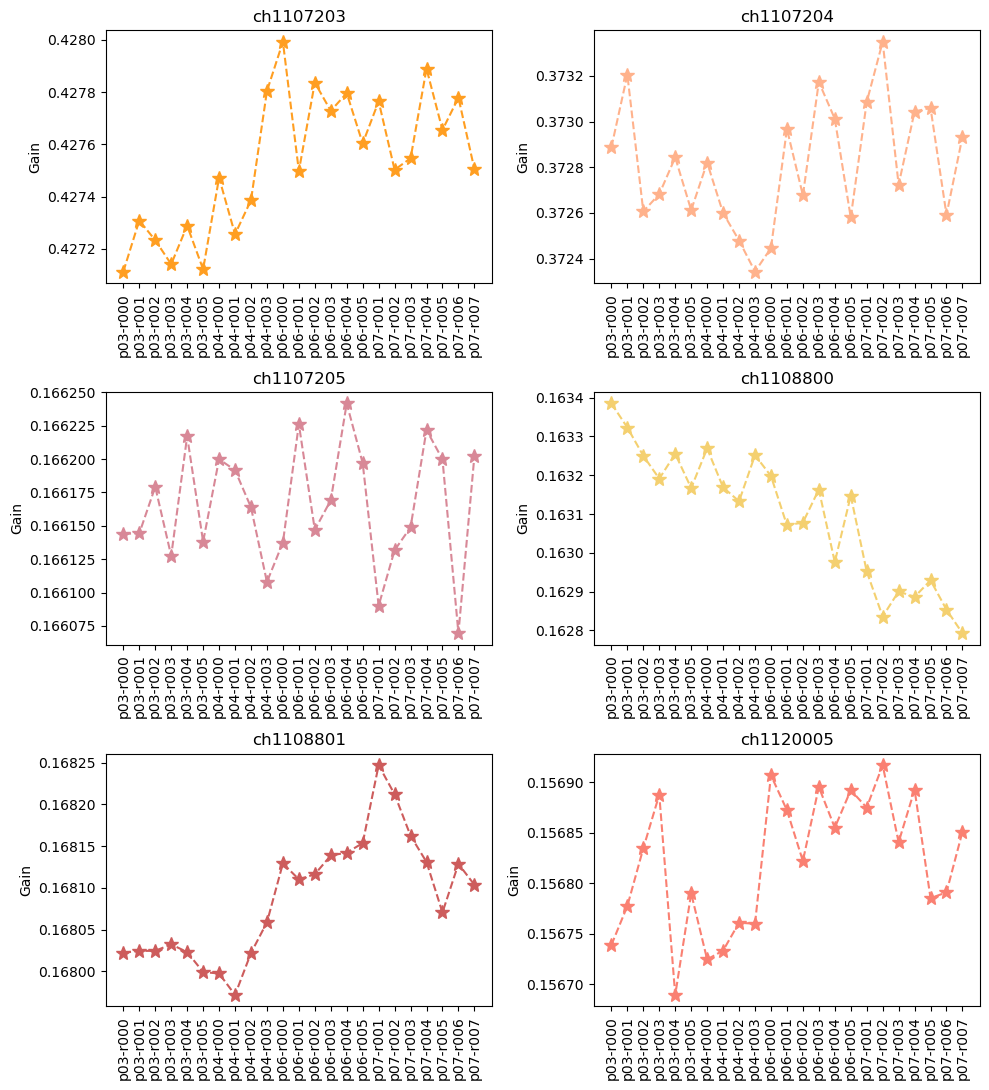

In [18]:
fig, axs = plt.subplots(3, 2, figsize=(10, 11))
for ax, channel, col in zip(axs.flatten(), all_channels, det_colors):
    ax.errorbar([list(i.keys  ())[0] for i in all_params_ch[channel]['gains']],
                [list(i.values())[0] for i in all_params_ch[channel]['gains']],
                 marker='*', linestyle='--', markersize=10, label=f'Channel {channel}', color=col)
    ax.set_ylabel('Gain')
    ax.tick_params(axis='x', labelsize=10, rotation=90)
    ax.set_title(channel)
plt.tight_layout()
plt.show()

### Residuals

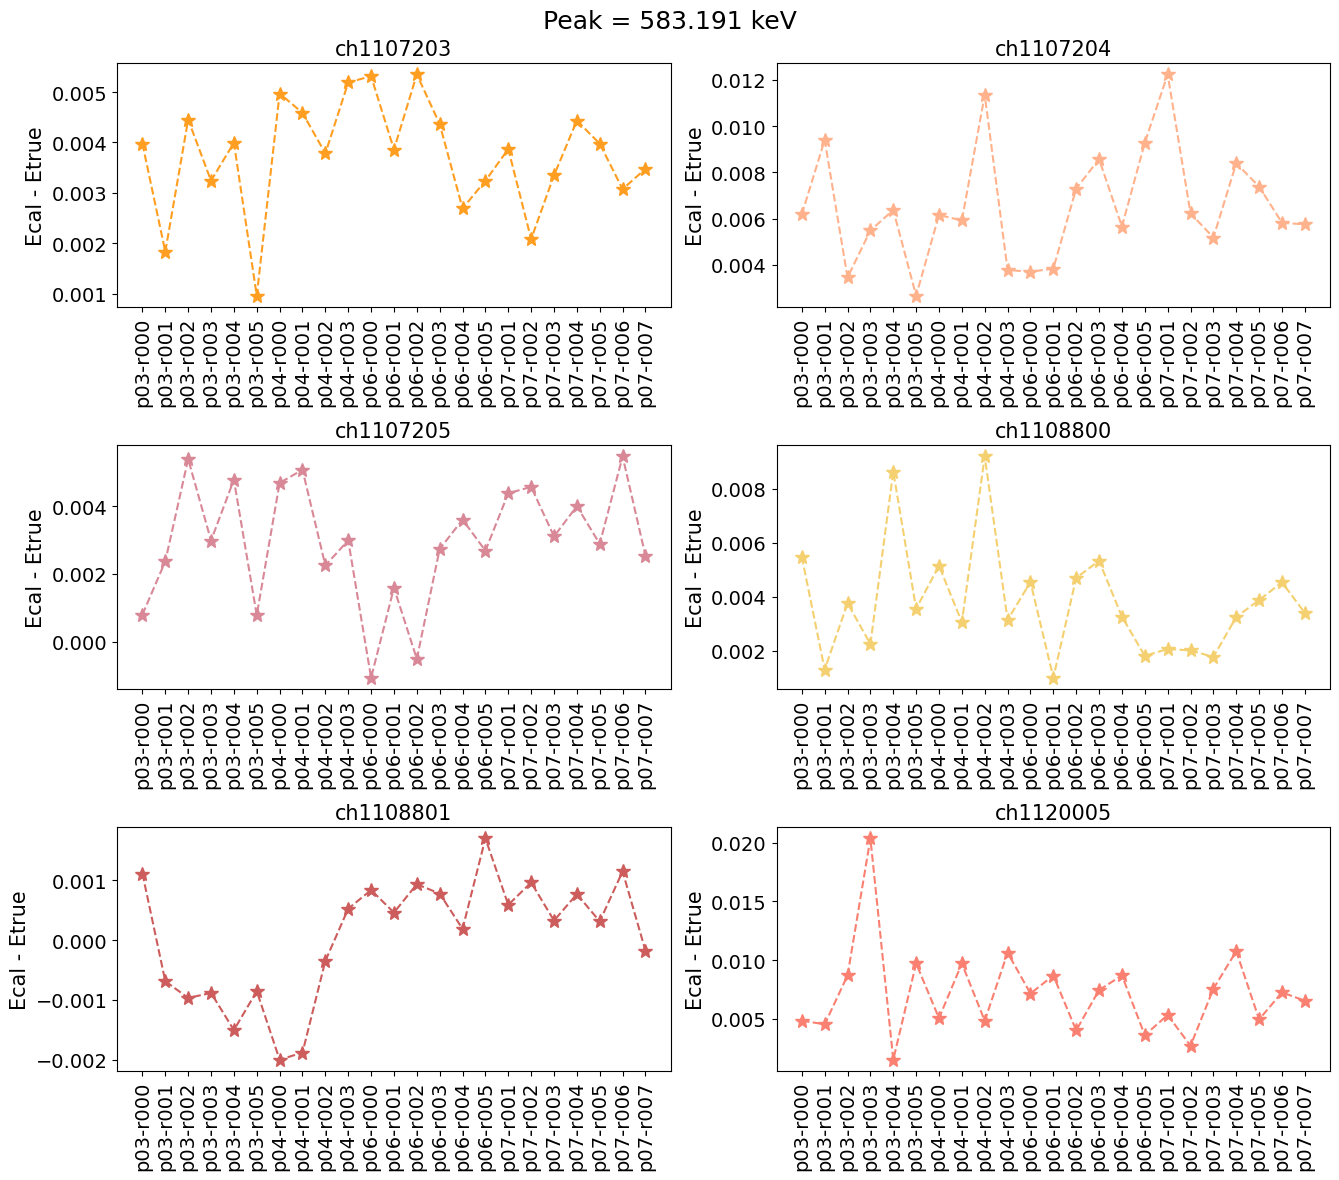


-------------------------------------------------------------------------------------------------



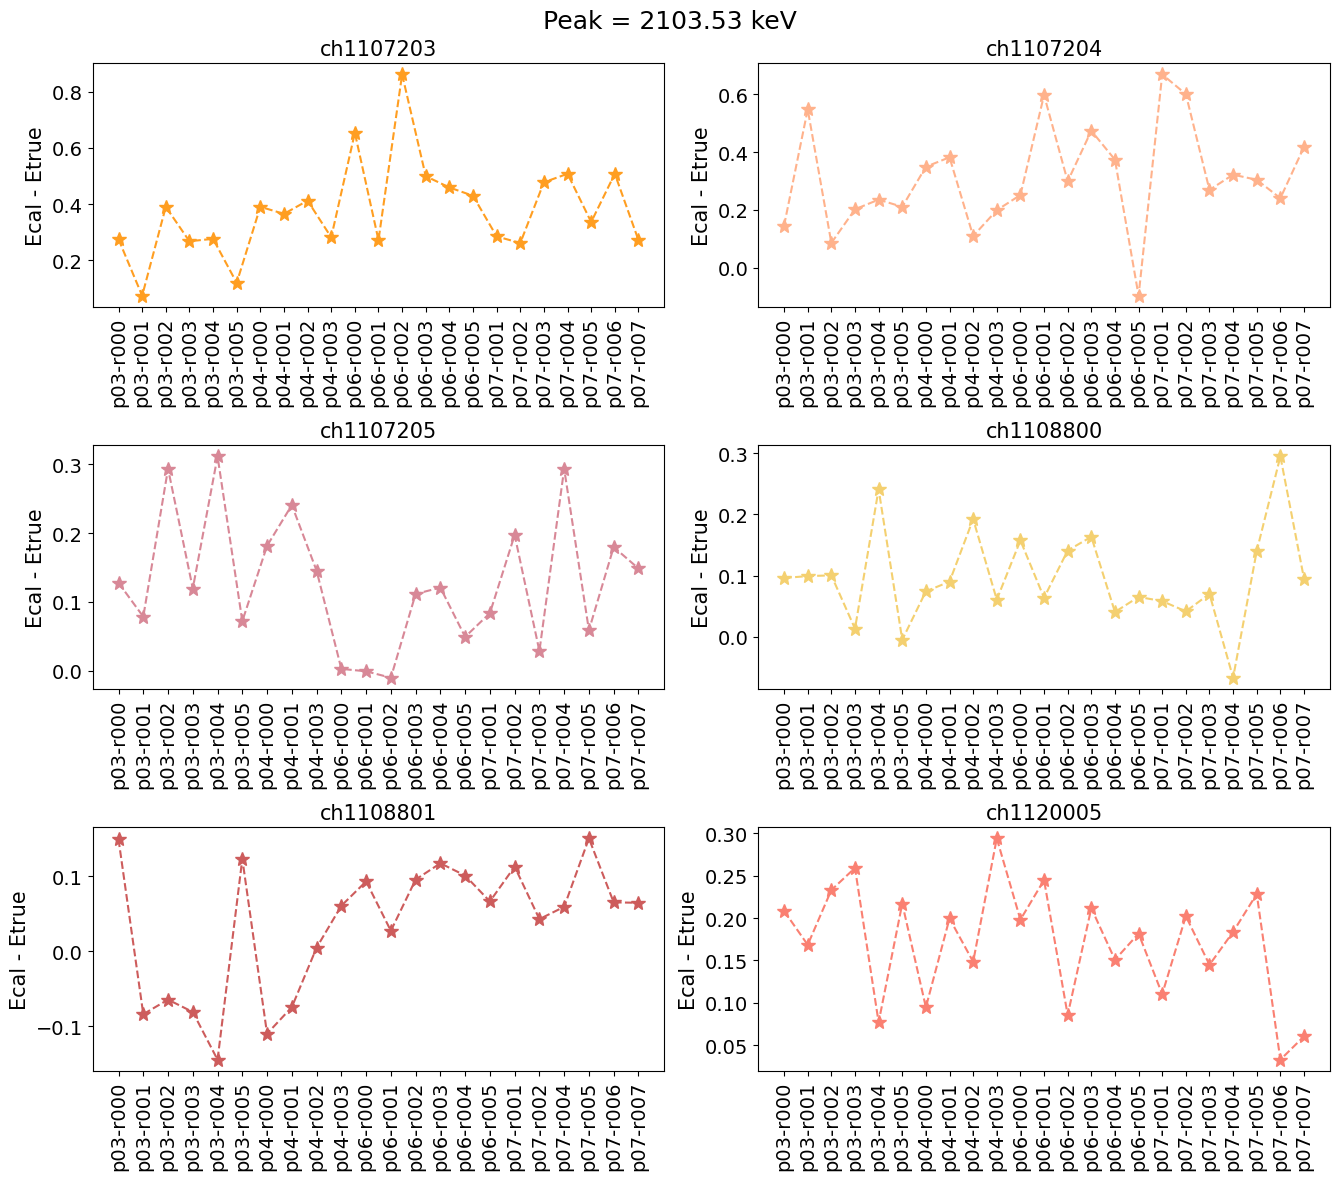


-------------------------------------------------------------------------------------------------



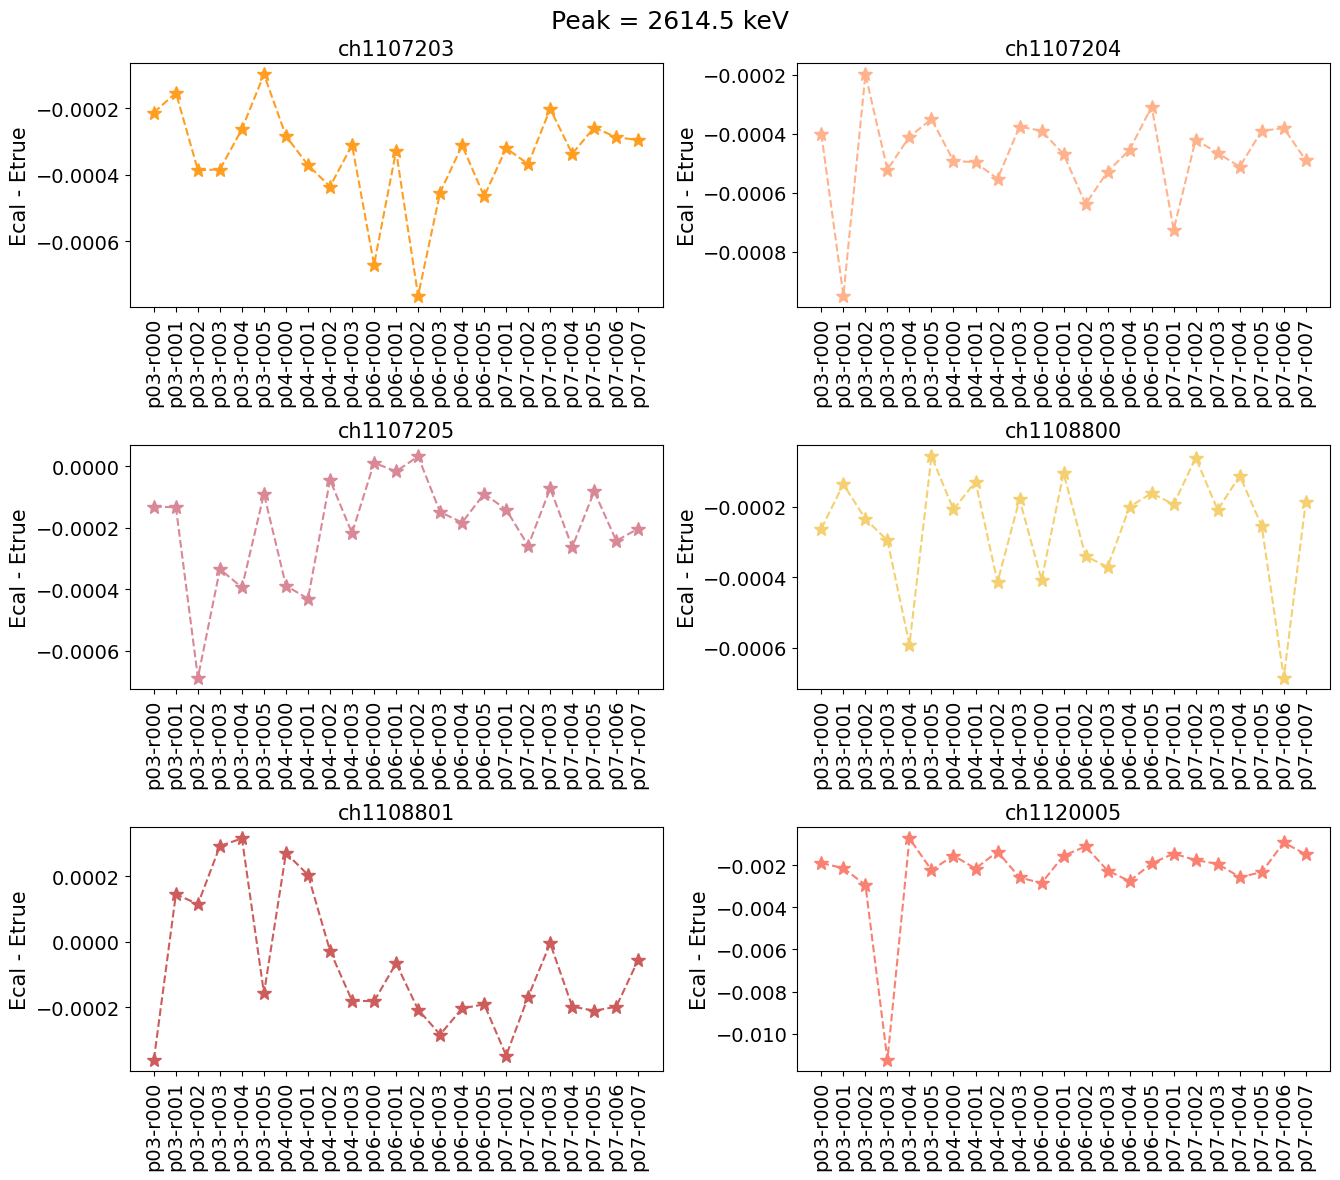


-------------------------------------------------------------------------------------------------



In [19]:
for peak in [all_fitted_peaks[0], all_fitted_peaks[5], all_fitted_peaks[6]]:
    fig, axs = plt.subplots(3, 2, figsize=(13.5, 12))
    for i, (ax, channel, col) in enumerate(zip(axs.flatten(), all_channels, det_colors)):
        ax.errorbar(list(all_params_ch[channel]['ecals_peaks'][peak].keys()), 
                    np.array(list(all_params_ch[channel]['ecals_peaks'][peak].values())) - peak,
                    marker='*', linestyle='--', markersize=10, label=channel, color=col)
        ax.tick_params(axis='x', labelsize=14, rotation=90)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_title(channel, fontsize=15)
        ax.set_ylabel('Ecal - Etrue', fontsize=15)
    fig.suptitle(f'Peak = {peak} keV', fontsize=18)
    plt.tight_layout()
    plt.show()
    print()
    print('-------------------------------------------------------------------------------------------------')
    print()

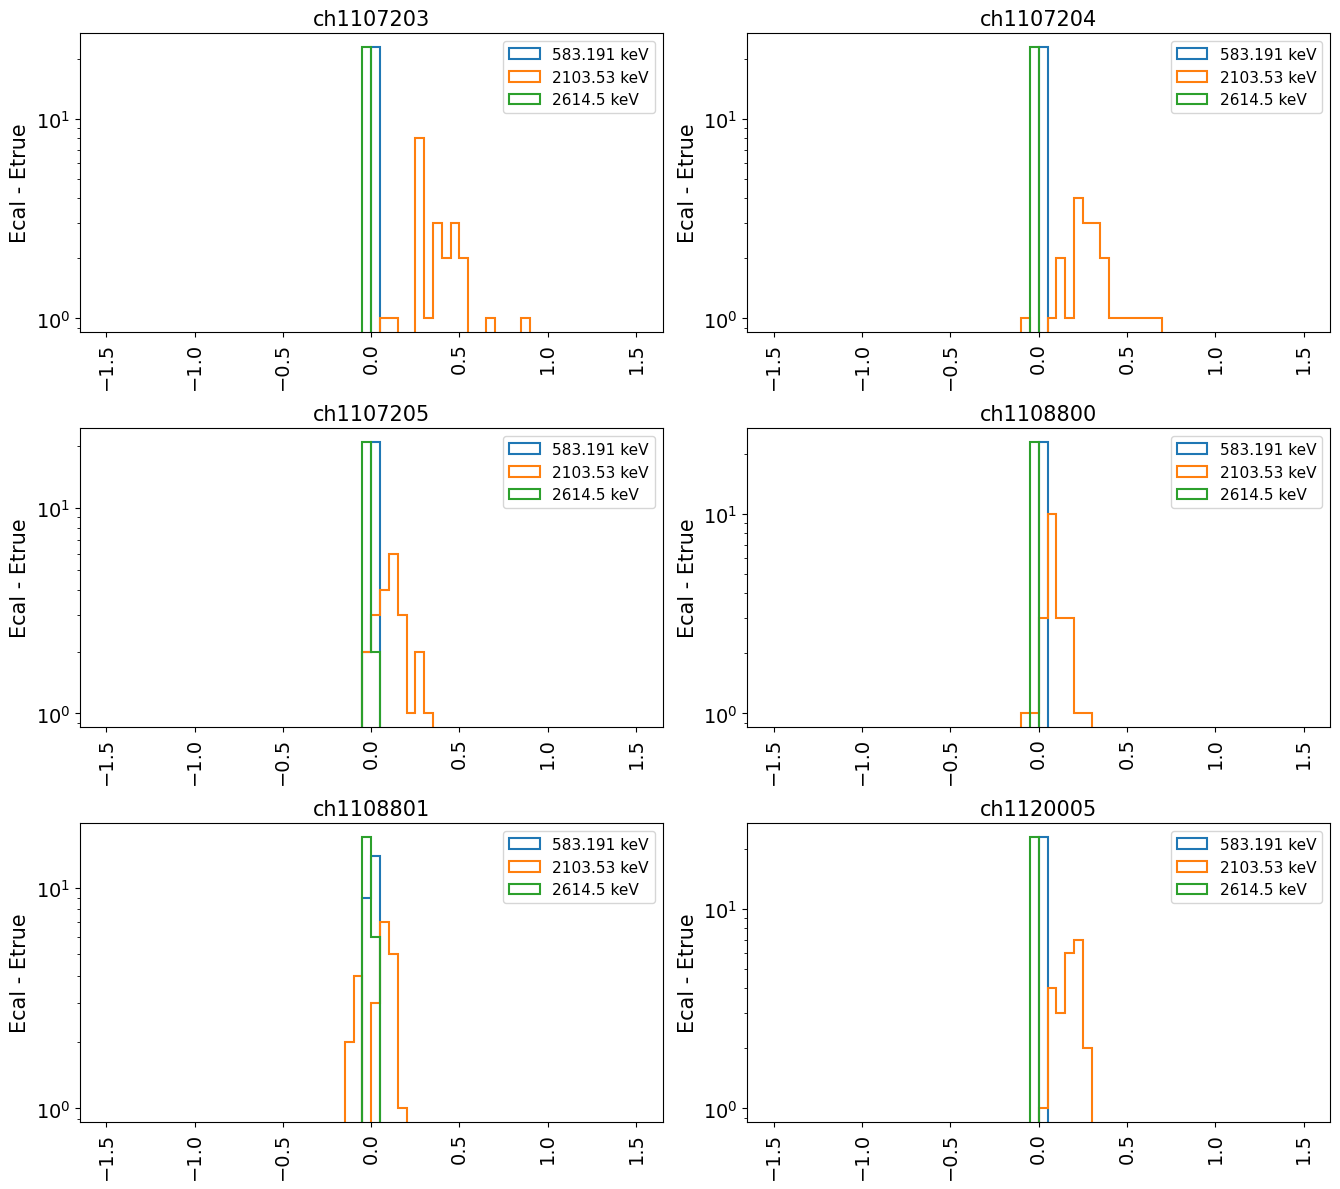

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(13.5, 12))
for i, (ax, channel) in enumerate(zip(axs.flatten(), all_channels)):
    for peak in [all_fitted_peaks[0], all_fitted_peaks[5], all_fitted_peaks[6]]:
        ax.hist(np.array(list(all_params_ch[channel]['ecals_peaks'][peak].values())) - peak, bins=60, range=(-1.5, 1.5), histtype='step', linewidth=1.5, label=f'{peak} keV')
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(channel, fontsize=15)
    ax.set_ylabel('Ecal - Etrue', fontsize=15)
    #ax.set_xlim(-0.5, 0.5)
    ax.set_yscale('log')
    ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

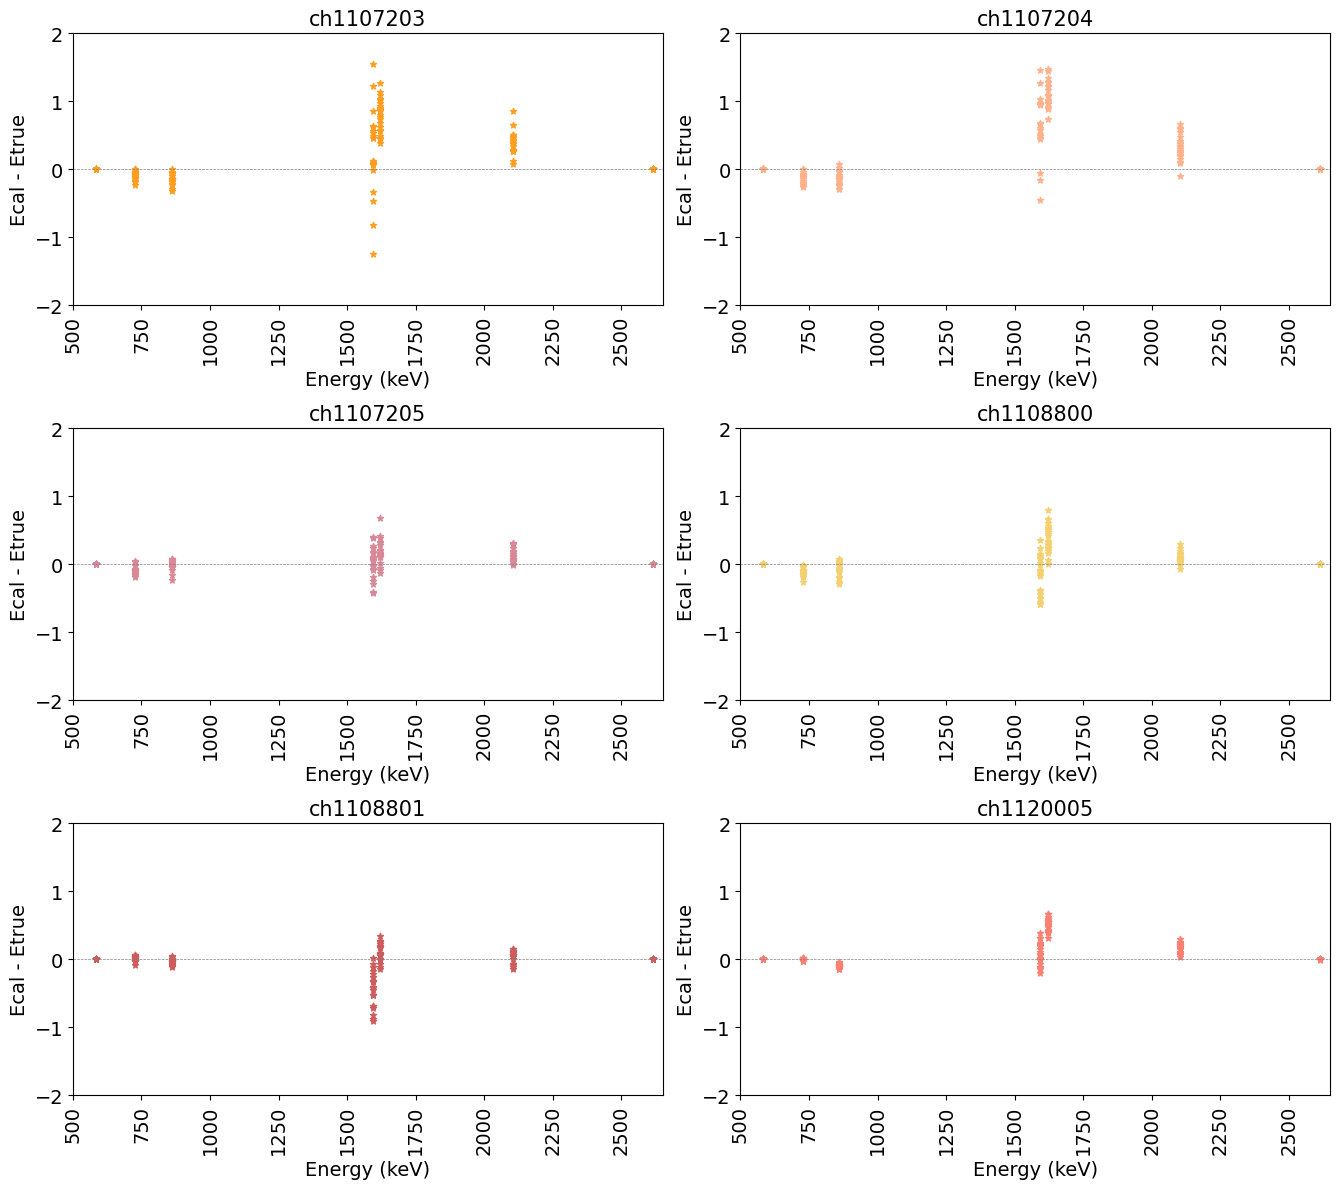

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(13.5, 12))
for i, (ax, channel, col) in enumerate(zip(axs.flatten(), all_channels, det_colors)):
    ax.axhline(y=0, linestyle='--', linewidth=0.5, color='grey')
    for i, peak in enumerate(all_fitted_peaks):
        ax.scatter(np.full(len(all_params_ch[channel]['ecals_peaks'][peak].values()), peak), np.array(list(all_params_ch[channel]['ecals_peaks'][peak].values())) - peak, marker='*', s=20, color=col)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('Energy (keV)', fontsize=14)
    ax.set_ylabel('Ecal - Etrue', fontsize=14)
    ax.set_title(channel, fontsize=15)
    ax.set_xlim(500, 2650)
    ax.set_ylim(-2, 2)
plt.tight_layout()
plt.show()

### Gain and mu position

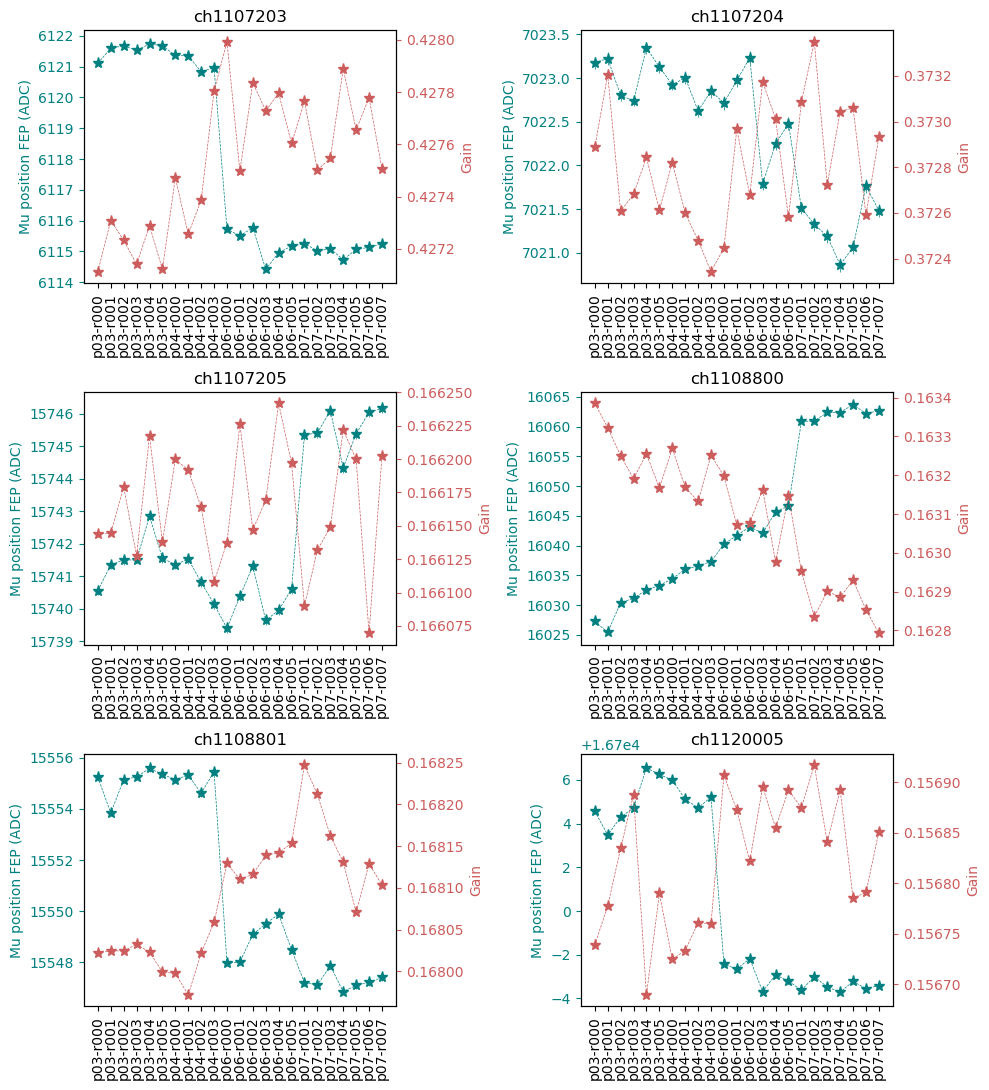

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(10, 11))
for ax, channel in zip(axs.flatten(), all_channels):
    ax2 = ax.twinx()    
    ax.errorbar(list(all_params_ch[channel]['mus_peaks'][2614.5].keys()), 
                 list(all_params_ch[channel]['mus_peaks'][2614.5].values()),
                 yerr=list(all_params_ch[channel]['mus_err_peaks'][2614.5].values()), 
                 marker='*', linestyle='--', markersize=8, label=channel, color='teal', linewidth=0.5)
    
    ax2.errorbar([list(i.keys  ())[0] for i in all_params_ch[channel]['gains']],
                [list(i.values())[0] for i in all_params_ch[channel]['gains']],
                 marker='*', linestyle='--', markersize=8, label=f'Channel {channel}', color='indianred', linewidth=0.5)
    ax.tick_params(axis='x', labelsize=10, rotation=90)
    ax.tick_params( axis='y', labelsize=10, colors='teal')
    ax2.set_ylabel('Gain', color='indianred')
    ax2.tick_params(axis='y', labelsize=10, colors='indianred')
    
    
    ax.set_ylabel('Mu position FEP (ADC)', color='teal')
    ax.tick_params(axis='x', labelsize=10, rotation=90)
    ax.set_title(channel)
    #ax.set_ylim(0.146, 0.16)
plt.tight_layout()
plt.show()

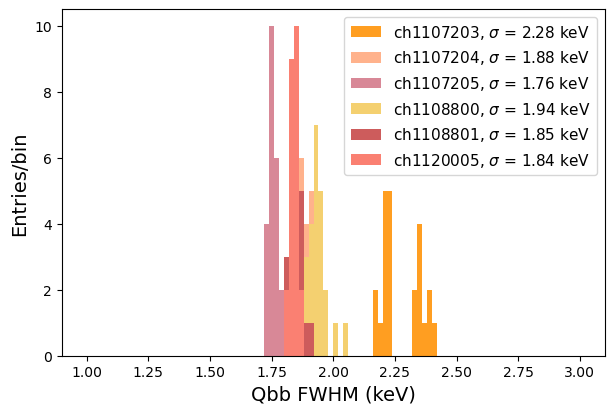

In [23]:
plt.figure(figsize=(7, 4.5))
for i, (channel, col) in enumerate(zip(all_channels, det_colors)):
    Qbb_fwhm_ch   = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
    Qbb_fwhm_keys = np.array([list(el.keys  ())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
    plt.hist(Qbb_fwhm_ch/2.355, bins=100, range=(1, 3), color=col, label=channel+f', $\sigma$ = {np.round(np.mean(Qbb_fwhm_ch/2.355), decimals=2)} keV')
plt.xlabel('Qbb FWHM (keV)', fontsize=14)
plt.ylabel('Entries/bin', fontsize=14)
plt.legend(fontsize=11)
plt.show()

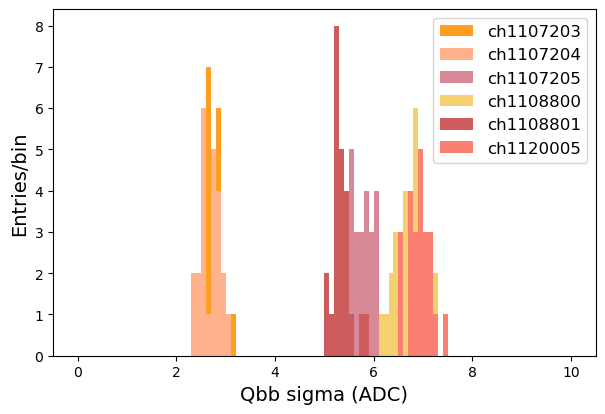

In [24]:
plt.figure(figsize=(7, 4.5))
for i, (channel, col) in enumerate(zip(all_channels, det_colors)):
    Qbb_fwhm_uncal = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])
    Qbb_sig_uncal  = Qbb_fwhm_uncal/2.355
    plt.hist(Qbb_sig_uncal, bins=100, range=(0, 10), color=col, label=channel)
plt.xlabel('Qbb sigma (ADC)', fontsize=14)
plt.ylabel('Entries/bin', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [25]:
def compute_and_plot_partition(channel, peak, col):
    mus    = list(all_params_ch[channel]['mus_peaks'][peak].values())
    sigmas = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])/2.355
    
    partition_change = [0]
    start_mu = 0
    for i,(mu,sig) in enumerate(zip(mus, sigmas)):
        if i==0:
            start_mu = mu
        else:
            if np.abs(mu - start_mu) > np.abs(sig):
                partition_change.append(i)
            start_mu = mu
    partition_change.append(len(mus)-1)
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    ax.errorbar(list(all_params_ch[channel]['mus_peaks'][peak].keys()), 
                list(all_params_ch[channel]['mus_peaks'][peak].values()),
                yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()), 
                marker='*', linestyle='--', markersize=10, label=det_type, color=col)
    for i,col in zip(range(len(partition_change)-1), ['teal', 'grey', 'orange']):
        ax.axvspan(list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i]], 
                   list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i+1]], alpha=0.2, color=col)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_title(f'{det_type}, ({det_name})', fontsize=15)
    ax.set_ylabel('Mu position (ADC)', fontsize=15)
    ax.set_ylim(np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))-25,
                np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))+25)
        
    plt.show()

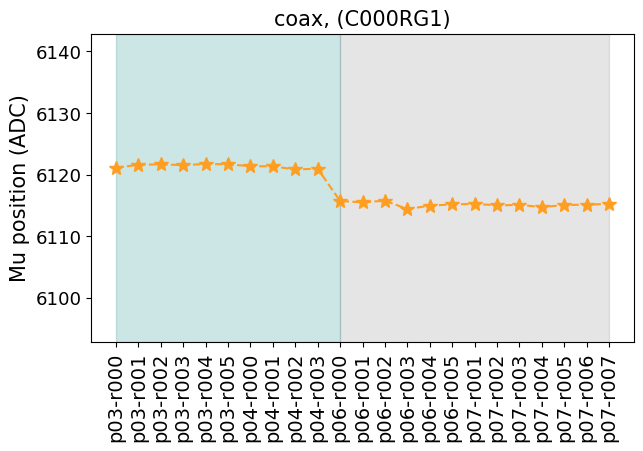

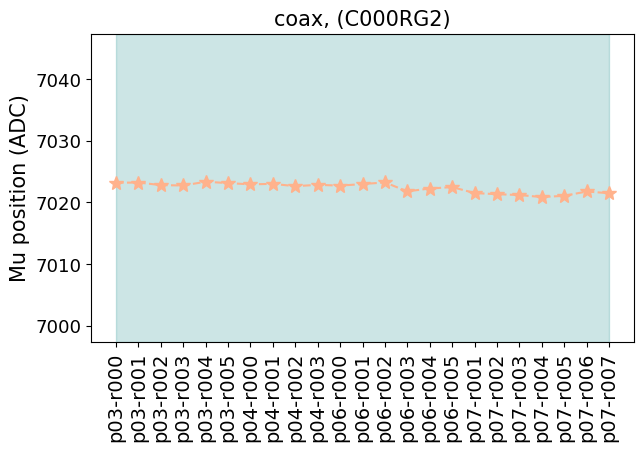

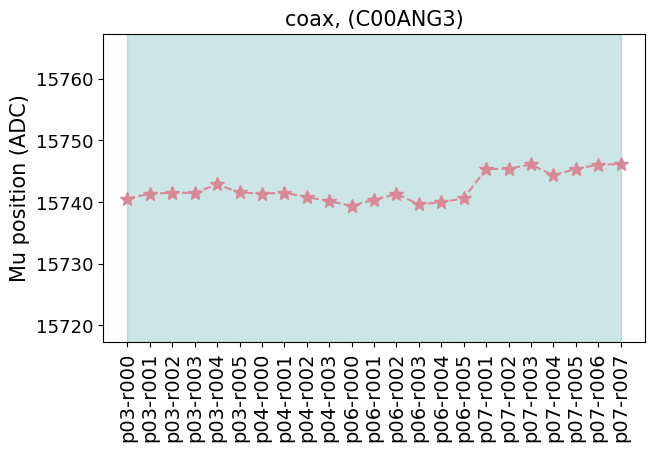

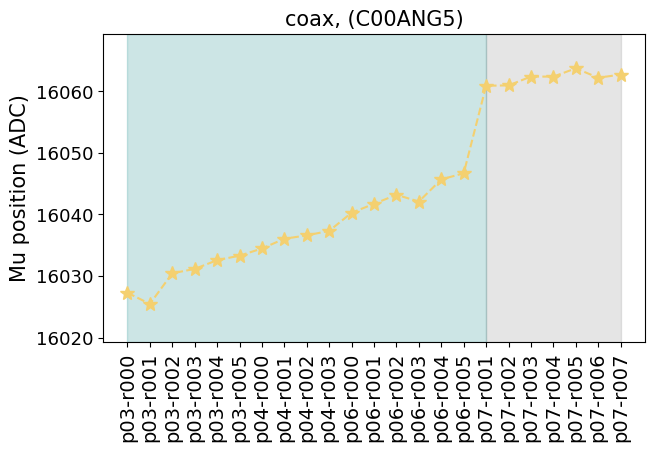

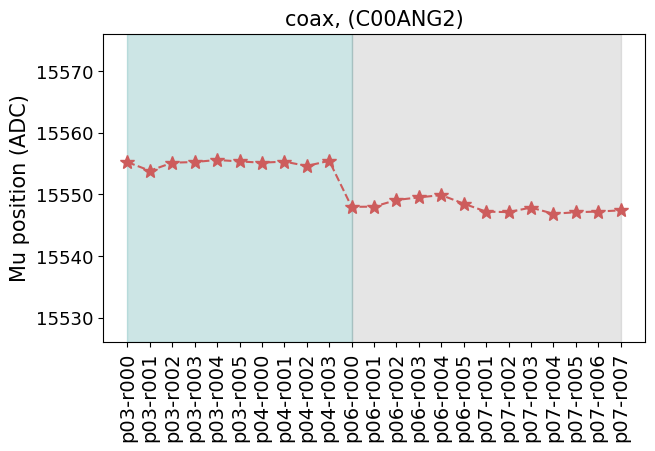

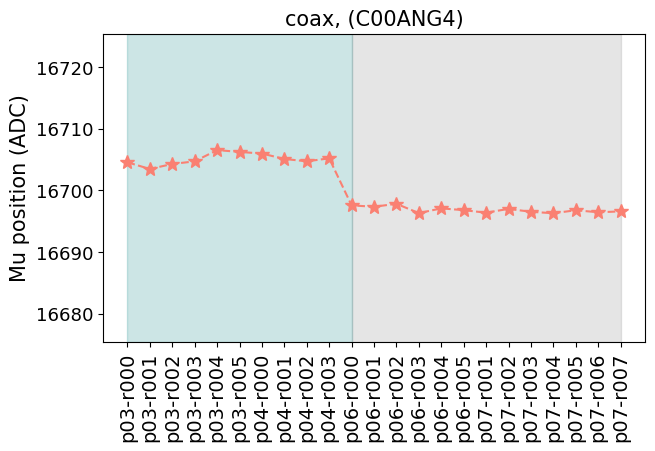

In [26]:
for channel, col in zip(all_channels, det_colors):
    compute_and_plot_partition(channel, all_fitted_peaks[6], col)

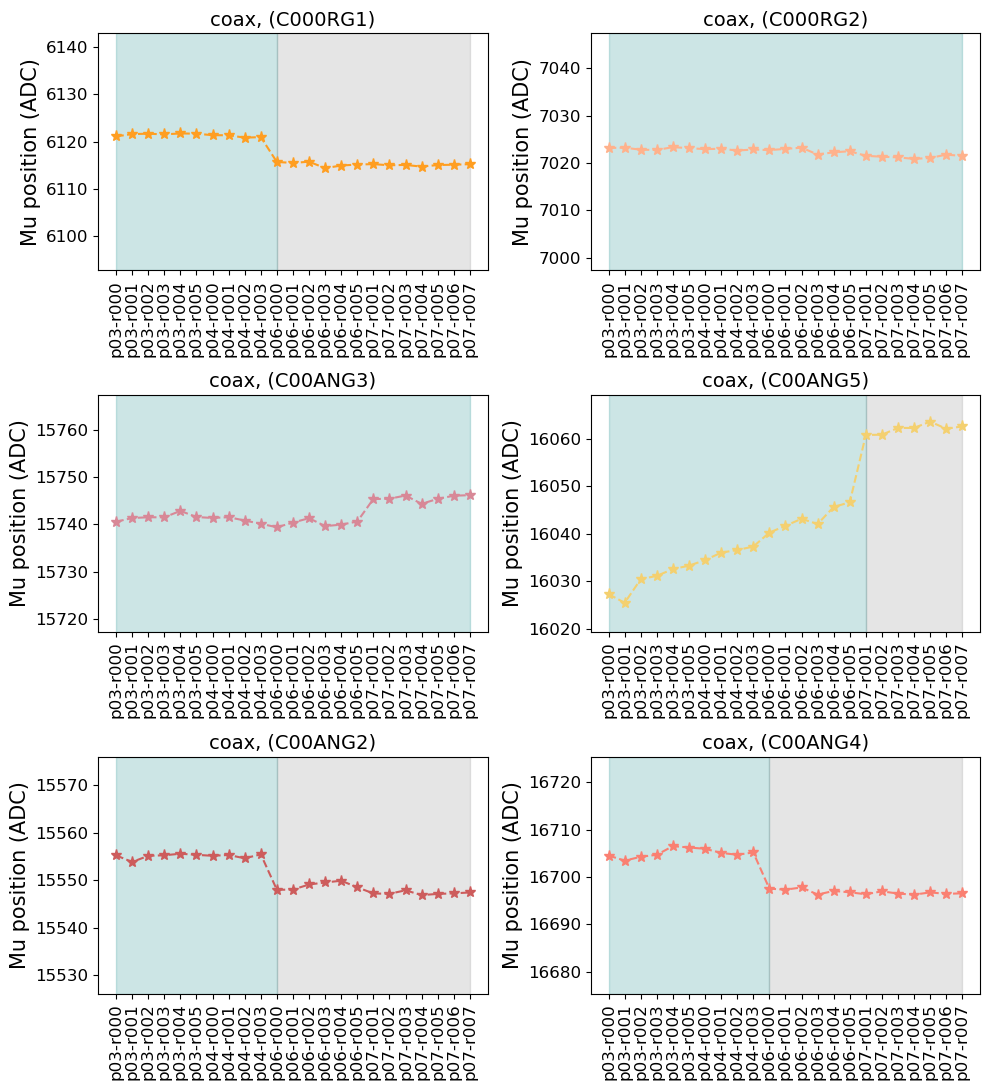

In [27]:
peak = all_fitted_peaks[6]
fig, axs = plt.subplots(3, 2, figsize=(10, 11))
for i, (ax, channel, col) in enumerate(zip(axs.flatten(), all_channels, det_colors)):
    mus    = list(all_params_ch[channel]['mus_peaks'][peak].values())
    sigmas = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])/2.355
    
    partition_change = [0]
    start_mu = 0
    for i,(mu,sig) in enumerate(zip(mus, sigmas)):
        if i==0:
            start_mu = mu
        else:
            if np.abs(mu - start_mu) > np.abs(sig):
                partition_change.append(i)
            start_mu = mu
    partition_change.append(len(mus)-1)
    
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    ax.errorbar(list(all_params_ch[channel]['mus_peaks'][peak].keys()), 
                list(all_params_ch[channel]['mus_peaks'][peak].values()),
                yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()), 
                marker='*', linestyle='--', markersize=8, label=det_type, color=col)
    for i,col in zip(range(len(partition_change)-1), ['teal', 'grey', 'orange']):
        ax.axvspan(list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i]], 
                   list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i+1]], alpha=0.2, color=col)
    ax.tick_params(axis='x', labelsize=12, rotation=90)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_title(f'{det_type}, ({det_name})', fontsize=14)
    ax.set_ylabel('Mu position (ADC)', fontsize=15)
    ax.set_ylim(np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))-25,
                np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))+25)
    
plt.tight_layout()    
plt.show()

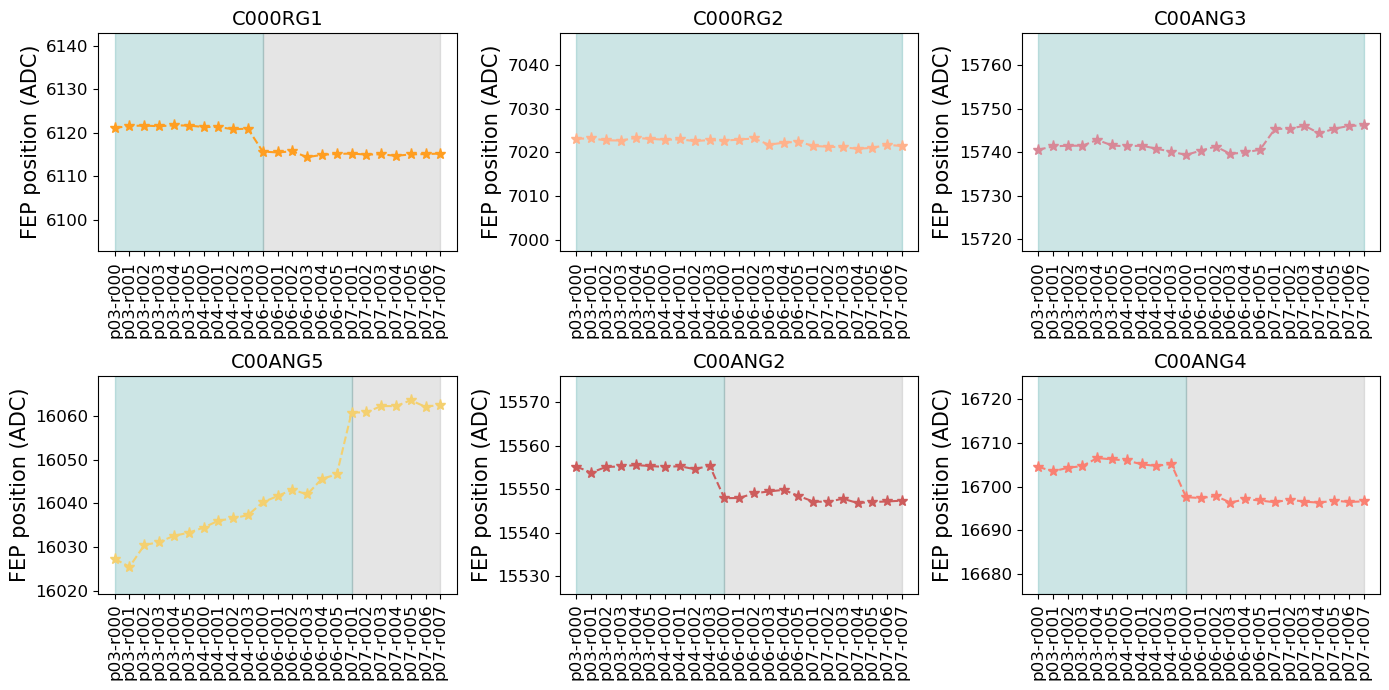

In [28]:
peak = all_fitted_peaks[6]
fig, axs = plt.subplots(2, 3, figsize=(14, 7))
for i, (ax, channel, col) in enumerate(zip(axs.flatten(), all_channels, det_colors)):
    mus    = list(all_params_ch[channel]['mus_peaks'][peak].values())
    sigmas = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])/2.355
    
    partition_change = [0]
    start_mu = 0
    for i,(mu,sig) in enumerate(zip(mus, sigmas)):
        if i==0:
            start_mu = mu
        else:
            if np.abs(mu - start_mu) > np.abs(sig):
                partition_change.append(i)
            start_mu = mu
    partition_change.append(len(mus)-1)
    
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    ax.errorbar(list(all_params_ch[channel]['mus_peaks'][peak].keys()), 
                list(all_params_ch[channel]['mus_peaks'][peak].values()),
                yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()), 
                marker='*', linestyle='--', markersize=8, label=det_type, color=col)
    for i,col in zip(range(len(partition_change)-1), ['teal', 'grey', 'orange']):
        ax.axvspan(list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i]], 
                   list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i+1]], alpha=0.2, color=col)
    ax.tick_params(axis='x', labelsize=12, rotation=90)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_title(f'{det_name}', fontsize=14)
    ax.set_ylabel('FEP position (ADC)', fontsize=15)
    ax.set_ylim(np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))-25,
                np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))+25)
    
plt.tight_layout()    
plt.show()